In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F

# MultiShapeDataset
1. คลาส MultiShapeDataset ถูกสร้างเพื่อ สุ่ม รูปร่าง (วงกลมหรือสี่เหลี่ยม) บนภาพ ขนาด 64×64 (หรือขนาดที่กำหนดเอง) โดยให้มี จำนวนวัตถุสูงสุด ตามค่า max_objects
2. ในการสุ่ม สคริปต์จะ ป้องกันการซ้อนทับกันเกิน 70% เพื่อให้วัตถุมีความหลากหลายและมี label ที่ชัดเจน
3. เมื่อต้องการใช้งานจริงกับ PyTorch ก็เพียงสร้าง dataset และส่งเข้า DataLoader เช่น
```python
dataset = MultiShapeDataset(num_samples=1000, image_size=(64, 64), max_objects=2)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
```
4. แต่ละครั้งที่เข้าถึง (ด้วย for imgs, labels in dataloader:) เราจะได้เทนเซอร์ imgs (B, 1, 64, 64) และเทนเซอร์ labels (B, max_objects, 5)
 * labels[:, :, 0] คือ index ของ shape (0 = circle, 1 = rectangle, -1 คือไม่มีวัตถุ)
 * labels[:, :, 1:3] คือ (center_x, center_y) แบบ normalized
 * labels[:, :, 3:5] คือ (width, height) แบบ normalized

In [2]:
class MultiShapeDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(64, 64), max_objects=2):
        self.num_samples = num_samples
        self.image_size = image_size
        self.min_size = min(image_size)
        self.max_objects = max_objects
        self.shapes = ['circle', 'rectangle']
        self.data = []
        self.generate_data()

    def generate_data(self):
        n_im = 0
        while n_im < self.num_samples:
            img = np.zeros((self.image_size[1], self.image_size[0]), dtype=np.float32)
            labels = []
            shapes_list = []
            num_objects = np.random.randint(1, self.max_objects + 1)  # จำนวนวัตถุที่สุ่มได้

            # 1) สุ่มสร้างวัตถุ (num_objects ชิ้น)
            for _ in range(num_objects):
                shape = np.random.choice(self.shapes)  # เลือกว่าเป็น circle หรือ rectangle

                if shape == 'circle':
                    # -----------------------------
                    # กรณีเป็นวงกลม (circle)
                    # -----------------------------

                    min_r = self.min_size // 10
                    r = np.random.randint(min_r, (self.min_size - min_r) // 2)  # สุ่มรัศมี
                    x = np.random.randint(r, self.image_size[0] - r)           # จุดศูนย์กลาง x
                    y = np.random.randint(r, self.image_size[1] - r)           # จุดศูนย์กลาง y

                    # สร้าง grid ในแกน (y, x)
                    rr, cc = np.ogrid[:self.image_size[1], :self.image_size[0]]
                    dist = np.sqrt((rr - y) ** 2 + (cc - x) ** 2)  # คำนวณระยะจากจุด (x, y)
                    shape_mask = (dist <= r)                      # ส่วนที่อยู่ในรัศมีจะเป็น True

                    # w, h เป็นเส้นผ่านศูนย์กลาง (2*r)
                    w, h = 2 * r, 2 * r

                    # คำนวณพื้นที่ (จำนวน pixel) ของ mask
                    area = np.sum(shape_mask)

                else:
                    # -----------------------------
                    # กรณีเป็นสี่เหลี่ยม (rectangle)
                    # -----------------------------

                    min_w = self.image_size[1] // 10  # ความกว้างขั้นต่ำ
                    min_h = self.image_size[0] // 10  # ความสูงขั้นต่ำ
                    w = np.random.randint(min_w, (self.image_size[1] - min_w) // 2)  # สุ่มความกว้าง
                    h = np.random.randint(min_h, (self.image_size[0] - min_h) // 2)  # สุ่มความสูง

                    # สุ่มตำแหน่งกึ่งกลาง (x, y)
                    x = np.random.randint(w // 2, self.image_size[0] - w // 2)
                    y = np.random.randint(h // 2, self.image_size[1] - h // 2)

                    # สร้าง mask ว่า pixel ไหนบ้างเป็นรูปสี่เหลี่ยม
                    shape_mask = np.zeros_like(img, dtype=bool)
                    shape_mask[
                        max(0, y - h // 2) : min(self.image_size[1], y + h // 2),
                        max(0, x - w // 2) : min(self.image_size[0], x + w // 2)
                    ] = True

                    # พื้นที่ (จำนวน pixel) ของ mask
                    area = np.sum(shape_mask)

                # เก็บรายละเอียดของ shape แต่ละอันในรูปแบบ tuple
                # (area, shape_mask, shape, x, y, w, h)
                shapes_list.append((area, shape_mask, shape, x, y, w, h))

            # 2) จัดเรียงวัตถุจากใหญ่ -> เล็ก (descending order) ตามค่า area
            shapes_list.sort(reverse=True, key=lambda x: x[0])

            # 3) ไล่เพิ่มวัตถุแต่ละตัวลงในรูปภาพ (img)
            for area, shape_mask, shape, x, y, w, h in shapes_list:
                # overlap = บริเวณที่ shape นี้ทับกับวัตถุที่มีอยู่แล้วบนภาพ (1 คือวัตถุ)
                overlap = np.logical_and(shape_mask, img)
                overlap_area = np.sum(overlap)      # ขนาดพื้นที่ที่ซ้อนกัน
                shape_area = np.sum(shape_mask)     # ขนาดพื้นที่ทั้งหมดของ shape

                # ถ้าพื้นที่วัตถุซ้อนเกินกว่า 70% จะไม่วาดวัตถุนี้ลงไป
                if shape_area > 0 and (overlap_area / shape_area) < 0.7:
                    # ถ้าซ้อนไม่เกิน 70% ก็ใส่ (1) ลงใน img ตาม mask
                    img[shape_mask] = 1
                    # สร้าง label: [ind_shape, center_x, center_y, width_norm, height_norm]
                    labels.append([
                        self.shapes.index(shape),  # 0 สำหรับ circle, 1 สำหรับ rectangle
                        x / self.image_size[0],    # Normalize ตำแหน่ง x
                        y / self.image_size[1],    # Normalize ตำแหน่ง y
                        w / self.image_size[0],    # Normalize ความกว้าง
                        h / self.image_size[1],    # Normalize ความสูง
                    ])

            # 4) ถ้าจำนวน label ยังไม่ถึง max_objects ให้เติม placeholder เข้าไป
            while len(labels) < self.max_objects:
                # ใส่ [-1, 0, 0, 0, 0] เป็นการบอกว่าไม่มีวัตถุ
                labels.append([-1, 0, 0, 0, 0])

            # 5) ถ้าภาพมีวัตถุจริง (pixel ที่เป็น 1 มีจำนวนมากกว่า 0)
            if np.sum(img) > 0:
                # เก็บ (img, labels) ไว้ใน self.data
                self.data.append((img, labels))
                n_im += 1  # สร้างภาพเสร็จไปแล้ว 1 ภาพ

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img, labels = self.data[idx]
        # img เป็น numpy array ขนาด (Height, Width) ต้องเปลี่ยนเป็น torch.tensor และ unsqueeze(0) เพื่อให้ shape กลายเป็น (1, H, W) (ทำเป็น channel 1)
        # labels ก็เปลี่ยนเป็น torch.tensor โดยจะมี shape ประมาณ (max_objects, 5) ตามที่เราเก็บไว้
        return torch.tensor(img).unsqueeze(0), torch.tensor(labels)


## สรุปการทำงาน generate_data
1. เริ่มจาก n_im = 0 แล้วทำซ้ำจนกว่าจะครบ num_samples
2. สร้างภาพว่าง (img) ขนาดตาม image_size (ค่าเริ่มต้น 64×64) โดยในตอนแรกค่าเป็นศูนย์ทั้งหมด
3. สุ่มจำนวนวัตถุ ตั้งแต่ 1 ชิ้นจนถึง max_objects
4. สำหรับวัตถุแต่ละชิ้น สุ่มว่าจะเป็นวงกลมหรือสี่เหลี่ยม
 * วงกลม (circle): สุ่มรัศมี r และตำแหน่ง (x, y) โดยคำนึงไม่ให้เกินขอบเขตภาพ
 * สี่เหลี่ยม (rectangle): สุ่มความกว้าง w ความสูง h และตำแหน่งกึ่งกลาง (x, y)
 * สร้าง mask (boolean array) เพื่อระบุพิกเซลใดเป็นรูปร่างนั้น ๆ
 * คำนวณ area = จำนวนพิกเซลที่เป็นวัตถุ
 * เก็บเป็น tuple (area, shape_mask, shape, x, y, w, h) เข้า shapes_list
5. เรียงลำดับ shapes_list จากรูปร่างที่มีพื้นที่มากที่สุดไปหาน้อยที่สุด (descending)
6. ตรวจสอบการซ้อนทับ (overlap) กับวัตถุที่มีอยู่บนภาพ
 * ถ้าซ้อนทับไม่เกิน 70% ของรูปใหม่ ก็เอารูปนั้นมาวางทับใน img (โดยเซ็ตเป็น 1) แล้วบันทึกค่าลงใน labels
7. เติม labels ให้ครบ max_objects หากใส่น้อยกว่า ก็ใส่ placeholder [-1, 0, 0, 0, 0]
8. ตรวจว่าในภาพมีวัตถุอย่างน้อย 1 ชิ้น (เช็ค np.sum(img) > 0) ถ้ามีก็เก็บ (img, labels) เข้า self.data และเพิ่มตัวนับ n_im
9. ทำซ้ำจนกว่าจะได้ num_samples ภาพที่มีวัตถุเรียบร้อย

# Lab10.1
10.1 เพิ่ม noise หรือ background แบบสุ่มในภาพ (เช่น ใส่ค่า random noise ลงไปใน pixel background) เพื่อให้ภาพไม่เป็น “ดำสนิท”

## Create Class To Make Noise

In [3]:
class MultiShapeNoisedDataset(MultiShapeDataset):
  def __init__(self, num_samples=1000, image_size=(64, 64), max_objects=2):
      super().__init__(num_samples, image_size, max_objects)
  def __getitem__(self, idx):
        img, labels = self.data[idx]
        # img เป็น numpy array ขนาด (Height, Width) ต้องเปลี่ยนเป็น torch.tensor และ unsqueeze(0) เพื่อให้ shape กลายเป็น (1, H, W) (ทำเป็น channel 1)
        # labels ก็เปลี่ยนเป็น torch.tensor โดยจะมี shape ประมาณ (max_objects, 5) ตามที่เราเก็บไว้

        # add noise
        noise = np.random.normal(0, 0.2, img.shape)
        img = torch.tensor(img).unsqueeze(0)

        noisy_image = img + noise
        noisy_image = np.clip(noisy_image, 0, 1)

        #return torch.tensor(img).unsqueeze(0), torch.tensor(labels)
        return noisy_image, torch.tensor(labels)

## Based Dataset

In [4]:
num_samples=1000
data=MultiShapeDataset(num_samples=num_samples, max_objects=5)

583
tensor([[ 1.0000,  0.5312,  0.3594,  0.2812,  0.4219],
        [ 1.0000,  0.4844,  0.7656,  0.4375,  0.1250],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


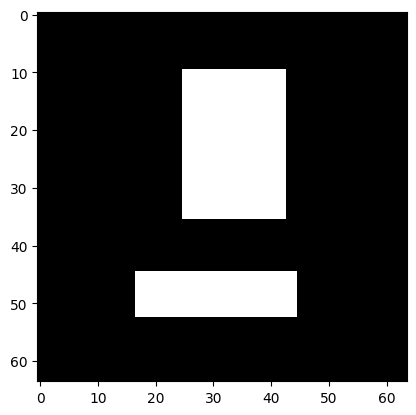

In [5]:
i=np.random.randint(0,num_samples)
print(i)
plt.imshow(data.__getitem__(i)[0][0],cmap='gray')
print(data.__getitem__(i)[1])

## Noised Dataset



```
index: 703
```



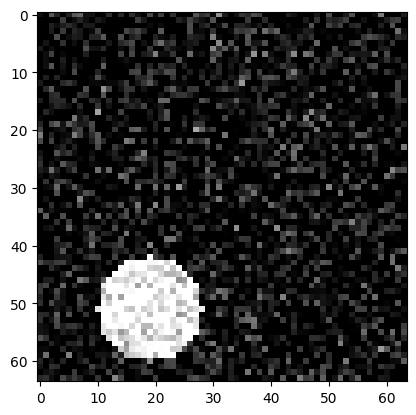

In [6]:
data_n=MultiShapeNoisedDataset(num_samples=num_samples, max_objects=5)

7
tensor([[0.0000, 0.3750, 0.7031, 0.5000, 0.5000],
        [0.0000, 0.7031, 0.7656, 0.4375, 0.4375],
        [1.0000, 0.1406, 0.7344, 0.2188, 0.4375],
        [1.0000, 0.8906, 0.5469, 0.1250, 0.2656],
        [1.0000, 0.2188, 0.1094, 0.1719, 0.1250]])


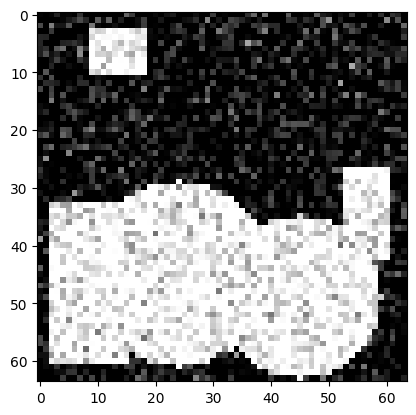

In [7]:
i=np.random.randint(0,num_samples)
print(i)
plt.imshow(data_n.__getitem__(i)[0][0],cmap='gray')
print(data_n.__getitem__(i)[1])

# โมดูล Attention สไตล์ CBAM ร่วมกับโครงสร้าง ResNet

## Convolutional Block Attention Module (CBAM)

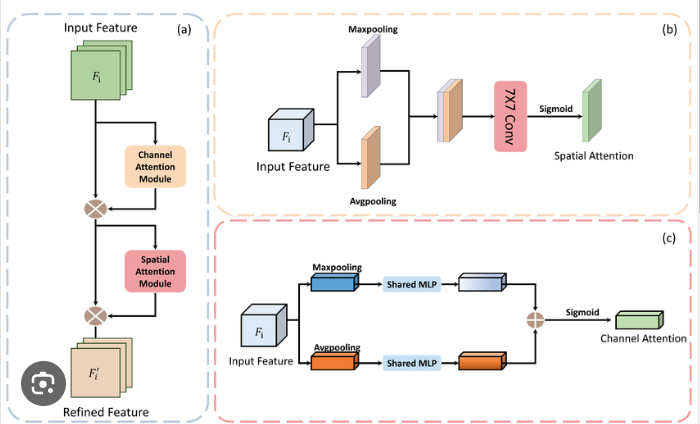

### 1) Channel Attention Module

In [4]:
# Define the Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Calculate each channels avg and max value in order to let network focus on overall info of different channel
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1), # C//r=1000/16=62
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(in_channels, in_channels // reduction_ratio),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(in_channels // reduction_ratio, in_channels)
        # )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # x=[B, C, H, W]
        avg_out = self.fc(self.avg_pool(x)) # [B, C, 1, 1]
        max_out = self.fc(self.max_pool(x)) # [B, C, 1, 1]
        out = avg_out + max_out
        return self.sigmoid(out)
        #return self.sigmoid(out) * x

1. รับพารามิเตอร์ in_channels (จำนวน channel ของ feature map) และ reduction_ratio (ค่าลดจำนวน channel เพื่อให้โมเดลเล็กลง)
2. self.avg_pool = nn.AdaptiveAvgPool2d(1)
 * ทำ Average Pooling ตามตำแหน่ง spatial (H×W) ลงมาเหลือขนาด 1×1
 * ผลลัพธ์ได้เทนเซอร์ขนาด [B, C, 1, 1] (B=Batch, C=Channels)
3. self.max_pool = nn.AdaptiveMaxPool2d(1)
 * ทำ Max Pooling ตามตำแหน่ง spatial (H×W) ลงมาเหลือขนาด 1×1
 * ผลลัพธ์ก็ได้ [B, C, 1, 1] อีกเช่นกัน
4. self.fc เป็น Sequential ประกอบด้วย
 * nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
ลดจำนวน channel จาก C ไปเป็น C//r (เช่น 64 → 4 ถ้า r=16)
 * nn.ReLU(inplace=True)
 * nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
5. เพิ่ม channel กลับมาเป็นขนาด C เช่นเดิม
self.sigmoid = nn.Sigmoid() เพื่อ scale ค่าให้อยู่ในช่วง [0, 1]
6. ขั้นตอนใน forward
 * avg_out = self.fc(self.avg_pool(x)):
นำค่าที่ผ่าน adaptive avg pooling (1×1) ไปเข้า Fully Connected (แต่ใช้ Conv1×1 แทน)
 * max_out = self.fc(self.max_pool(x)):
ทำแบบเดียวกันกับส่วน Max Pooling
 * out = avg_out + max_out:
รวม (element-wise) เพื่อให้ได้ค่าความสำคัญ (attention) ของแต่ละ channel
 * return self.sigmoid(out):
ทำ sigmoid ให้ค่าระหว่าง 0 ถึง 1 สุดท้ายได้ attention map ขนาด [B, C, 1, 1]


### 2) Spatial Attention Module

In [5]:
# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # DIM is in the first dimension, which is after the batch size, so it is defined as [B,1,H,W].
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [B, 1, H, W]
        x = torch.cat([avg_out, max_out], dim=1) # [B, 2, H, W]
        x = self.conv(x) # [B, 1, H, W]
        return self.sigmoid(x) # [B, 1, H, W] (final attention map)
        #return self.sigmoid(out) * x

1. รับพารามิเตอร์ kernel_size (ค่าเริ่มต้น=7) สำหรับ Convolution
2. self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
 * รับ 2 ช่อง (เนื่องจากเราจะ cat avg_out กับ max_out)
 * ได้ 1 ช่องเป็นผลลัพธ์ (attention map)
3. self.sigmoid = nn.Sigmoid() เพื่อให้ค่าระหว่าง 0 ถึง 1
4. ขั้นตอนใน forward
 * avg_out = torch.mean(x, dim=1, keepdim=True)
หา average ตามแกน channel => ได้ [B, 1, H, W]
 * max_out, _ = torch.max(x, dim=1, keepdim=True)
หา max ตามแกน channel => ได้ [B, 1, H, W]
 * x = torch.cat([avg_out, max_out], dim=1)
ต่อเทนเซอร์ในแกน channel => ได้ [B, 2, H, W]
 * x = self.conv(x)
Convolution 7×7 เพื่อเรียนรู้โครงสร้าง spatial
 * return self.sigmoid(x)
คืนค่าเป็นขนาด [B, 1, H, W] (spatial attention map)

### 3) CBAMAttention Module (Channel + Spatial)

In [6]:
# Define the CBAM-like Attention Module
class CBAMAttention(nn.Module):
    def __init__(self, in_channels):
        super(CBAMAttention, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x) # x* [B, C, 1, 1] = [B, C, H, W]
        x = x * self.spatial_att(x) # x * [B, 1, H, W] = [B, C, H, W]

        return x

1. ใช้โครงสร้าง Conv-BN-ReLU-Conv-BN ภายในบล็อกเดียวกัน
2. มี skip connection (out += identity) เพื่อส่งผ่านข้อมูลขาเข้าตรงไปที่ขาออก
3. ถ้า in_channels != out_channels จะต้องทำ downsample ด้วย Conv 1×1 และ BN เพื่อปรับขนาด channel ให้เท่ากัน

## ResidualBlock (Block ของ ResNet)
https://github.com/samcw/ResNet18-Pytorch/blob/master/ResNet18.ipynb

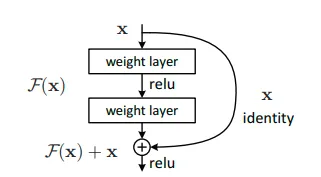

In [7]:
# Define a residual block with skip connection
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

# โครงสร้างเครือข่ายหลัก

## ResNet18 and ResNet18 with Attention

In [11]:
# Define networks
class ResNet18(nn.Module):
    def __init__(self, im_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(im_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 1)
        self.layer2 = self._make_layer(128, 2)
        self.layer3 = self._make_layer(256, 2)
        self.layer4 = self._make_layer(512, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Define networks
class ResNet18withAttention(nn.Module):
    def __init__(self,im_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(im_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 1)
        self.cbam1=CBAMAttention(64)
        self.layer2 = self._make_layer(128, 2)
        self.cbam2=CBAMAttention(128)
        self.layer3 = self._make_layer(256, 2)
        self.cbam3=CBAMAttention(256)
        self.layer4 = self._make_layer(512, 2)
        self.cbam4=CBAMAttention(512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.cbam1(self.layer1(out))
        out = self.cbam2(self.layer2(out))
        out = self.cbam3(self.layer3(out))
        out = self.cbam4(self.layer4(out))

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## ResNet with Attention nano

In [8]:
class ResNetwithAttention_nano(nn.Module):
    def __init__(self, im_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(im_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # สร้างเลเยอร์ (ResidualBlock) 2 ชุด
        self.layer1 = self._make_layer(64, 1)   # 1 block out_channels=64
        self.layer2 = self._make_layer(128, 2) # 2 blocks out_channels=128

        # CBAM Attention (กับจำนวน channel = 128)
        self.cbam = CBAMAttention(128)

        # Adaptive Average Pool -> 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1) Conv + BN + ReLU เริ่มต้น
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2) ผ่าน layer1 (1 Block) ขนาดยังเป็น 64 channels
        out = self.layer1(out)

        # 3) ผ่าน layer2 (2 Blocks) ขยายเป็น 128 channels
        out = self.layer2(out)

        # 4) ใส่ CBAM Attention
        out = self.cbam(out)

        # 5) Average Pool -> 1x1
        out = self.avg_pool(out)    # [B, 128, 1, 1]

        # 6) Flatten และผ่าน Fully Connected
        out = torch.flatten(out, 1) # [B, 128]
        out = self.fc(out)          # [B, num_classes]

        return out

**สรุปโครงสร้าง**

1. Conv1 + BN + ReLU รับภาพขนาด im_channels → ออกมาเป็น 64 channels
2. layer1 (มี 1 ResidualBlock) ใช้ out_channels=64 → ยังคง 64
3. layer2 (มี 2 ResidualBlock) สุดท้ายจะเป็น 128 channels
4. CBAMAttention(128) รับ feature ขนาด 128 channels มาทำ channel + spatial attention
5. AdaptiveAvgPool2d(1,1) ลด spatial เหลือ 1×1
6. Fully Connected (linear) output เป็น num_classes (เช่น 10)

การ forward(x) จึงมีลำดับตาม step ข้างต้น ส่งผลให้ได้ feature map ที่ถูกปรับแต่งด้วย attention ก่อนจะนำไปทำการ classify ในตอนท้าย

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count()
print(f"Using device: {device}")
print(f"Number of workers: {num_workers}")

Using device: cuda
Number of workers: 2


In [14]:
dataset = MultiShapeDataset(num_samples=500, max_objects=5)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True,num_workers=num_workers)

# Classification problem (ทำนายชนิดของวัตถุที่มีขนาดใหญ่ที่สุดในรูป)
ResNetwithAttention_nano (สำหรับภาพขาว-ดำ 1 channel และจำนวนคลาส 1) และฟังก์ชัน train_bigest_shape_model ซึ่งทำการเทรนโมเดลด้วย DataLoader, Loss, และ Optimizer ที่กำหนด
* ResNetwithAttention_nano(im_channels=1, num_classes=1)
เรียกใช้คลาส ResNetwithAttention_nano ซึ่งภายในกำหนดว่า
 * im_channels=1 หมายถึง Input มี 1 channel (เช่น ภาพ Grayscale หรือ single-channel)
 * num_classes=1 หมายถึง Output สุดท้ายของ FC Layer เป็น 1 neuron เท่านั้น
(มักใช้ในงาน Classification แบบ Binary หรือ Output เป็นค่าตัวเดียว)

In [ ]:
# Create and train the model
model = ResNetwithAttention_nano(im_channels=1,num_classes=1)
print(f"Total trainable parameters: {count_parameters(model)}")

def train_bigest_shape_model(model, train_loader,criterion,optimizer, num_epochs=20):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels[:,0][:,0].unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.cpu().item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

Total trainable parameters: 602732


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_bigest_shape_model(model, train_loader,criterion,optimizer, num_epochs=50)

## วัดประสิทธิภาพและทดสอบใช้งาน

Test Accuracy: 0.965


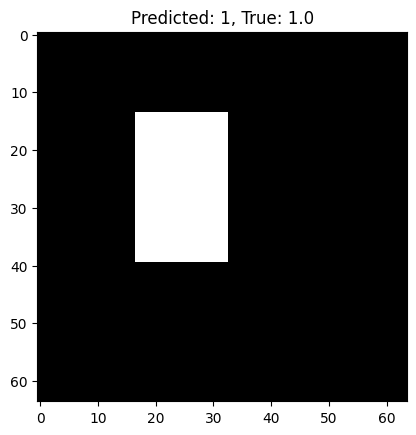

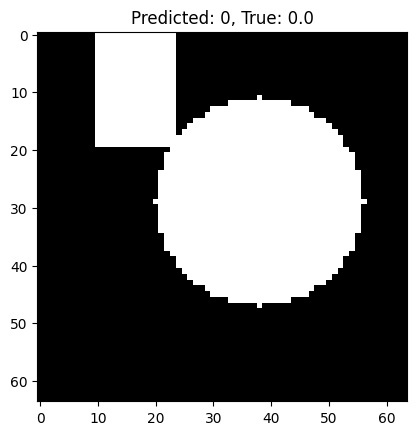

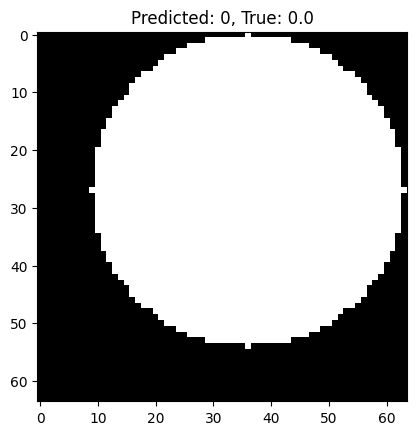

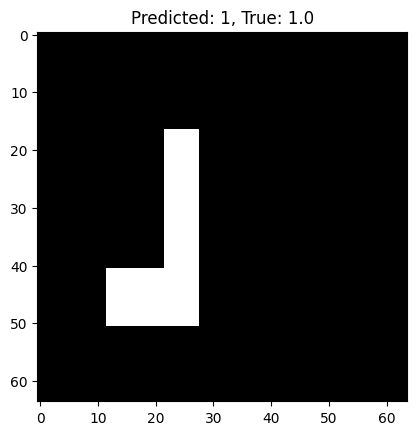

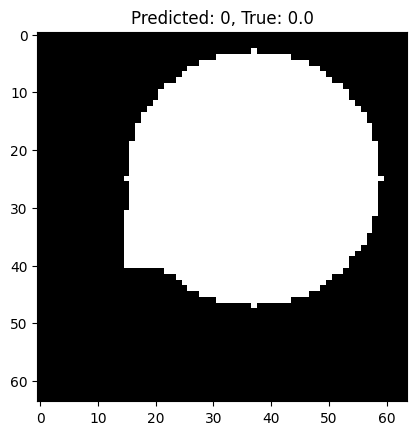

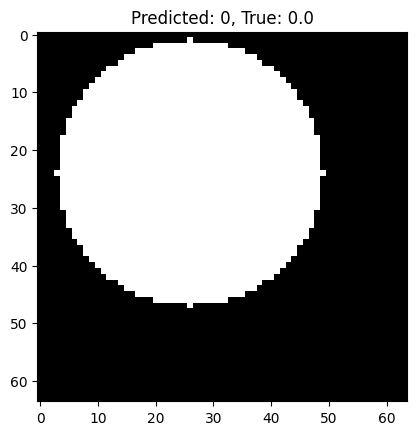

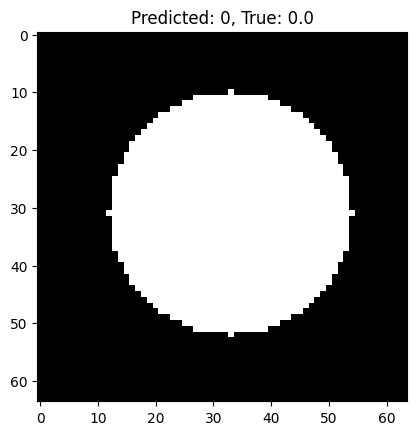

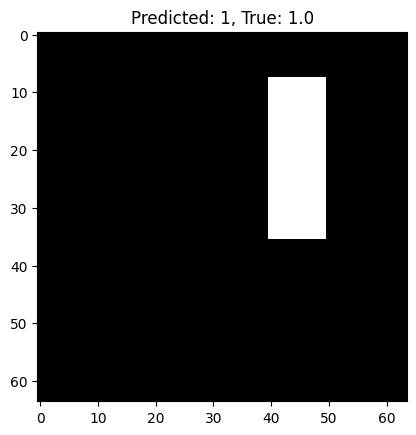

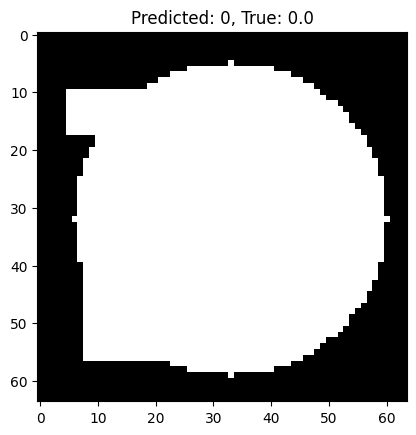

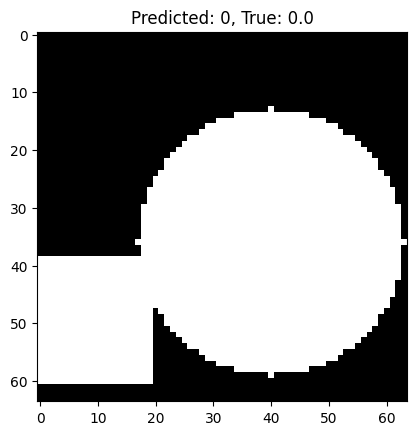

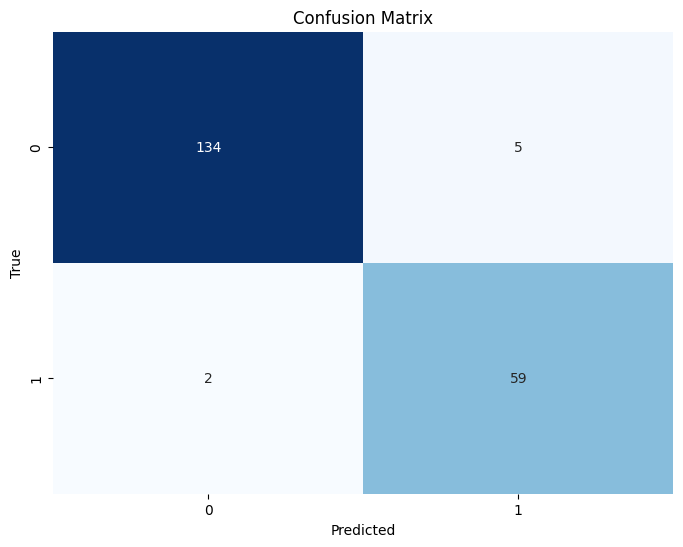

In [ ]:
# prompt: create inference and visualize model performance on new test set

import numpy as np
# Assuming the model and training process are complete as in the previous code.

# Create a new test dataset
test_dataset = MultiShapeDataset(num_samples=200, max_objects=5)  # Adjust num_samples as needed
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

# Function to perform inference and collect predictions
def perform_inference(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            predicted_labels = (outputs > 0.5).int()  # Convert probabilities to binary predictions
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels[:,0][:,0].unsqueeze(1).cpu().numpy())
    return np.array(predictions), np.array(true_labels)


# Perform inference on the test set
predictions, true_labels = perform_inference(model, test_loader)

# Calculate accuracy
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")


# Visualize some predictions (optional)
import matplotlib.pyplot as plt

# Example: Show the first 10 images with their predicted and true labels
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]
    predicted_label = predictions[i]
    plt.imshow(image.squeeze(), cmap='gray')  # Assuming grayscale images
    plt.title(f"Predicted: {predicted_label[0]}, True: {label[0][0]}")
    plt.show()


# Plot confusion matrix (optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Lab10.2 ทดลองทำนายเป็น 3 class
โดยที่
1. class (1,0,0) หมายถึง มีวงกลมอย่างเดียว
2. class (0,1,0) หมายถึง มีสี่เหลี่ยมอย่างเดียว
3. class (0,0,1) หมายถึง มีทั้งวงกลมและสี่เหลี่ยม

แนวทาง
* สร้างโมเดลใหม่โดยกำหนด num_classes=3 (เช่น model = ResNetwithAttention_nano(im_channels=1, num_classes=3))
* เปลี่ยน Loss function เช่นใช้ nn.CrossEntropyLoss() แทน เพื่อรองรับ multi-class
* ในฟังก์ชันเทรน (train_bigest_shape_model) ให้ตัด torch.sigmoid(outputs) ออก และปรับการคำนวณ Loss ตามรูปแบบ cross-entropy (softmax รวมอยู่แล้วภายใน nn.CrossEntropyLoss)


In [ ]:
# Create and train the model
model = ResNetwithAttention_nano(im_channels=1,num_classes=3)
print(f"Total trainable parameters: {count_parameters(model)}")

def train_bigest_shape_model(model, train_loader,criterion,optimizer, num_epochs=20):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels[:,0][:,0].long())
            loss.backward()
            optimizer.step()
            running_loss += loss.cpu().item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

Total trainable parameters: 602990


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_bigest_shape_model(model, train_loader,criterion,optimizer, num_epochs=10)

Epoch 1, Loss: 0.4752
Epoch 2, Loss: 0.2188
Epoch 3, Loss: 0.1487
Epoch 4, Loss: 0.1112
Epoch 5, Loss: 0.1102
Epoch 6, Loss: 0.1146
Epoch 7, Loss: 0.0979
Epoch 8, Loss: 0.0976
Epoch 9, Loss: 0.0992
Epoch 10, Loss: 0.0907




```
19/02/68

Epoch 1, Loss: 0.4752
Epoch 2, Loss: 0.2188
Epoch 3, Loss: 0.1487
Epoch 4, Loss: 0.1112
Epoch 5, Loss: 0.1102
Epoch 6, Loss: 0.1146
Epoch 7, Loss: 0.0979
Epoch 8, Loss: 0.0976
Epoch 9, Loss: 0.0992
Epoch 10, Loss: 0.0907
```



Test Accuracy: 0.6


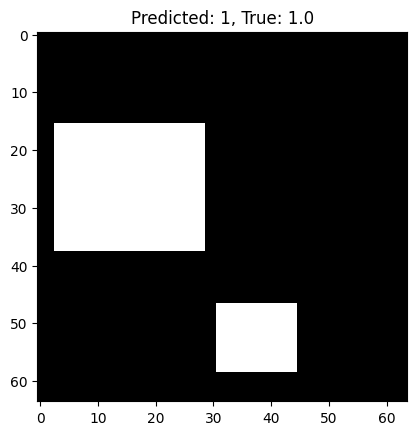

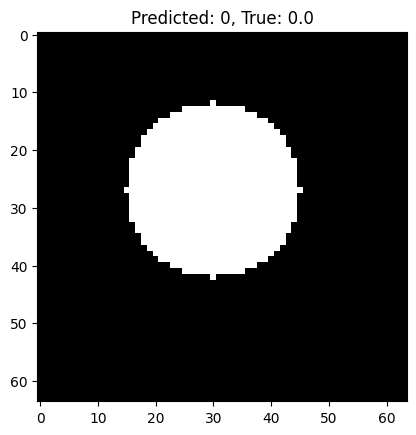

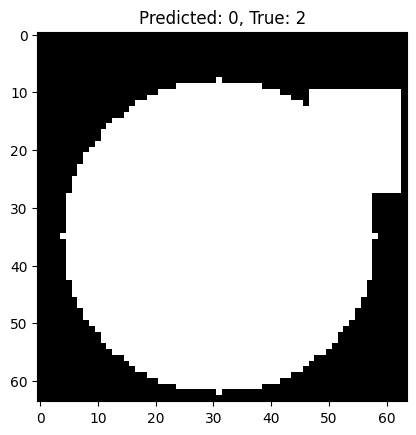

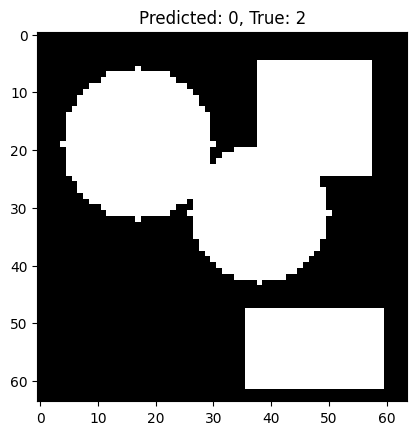

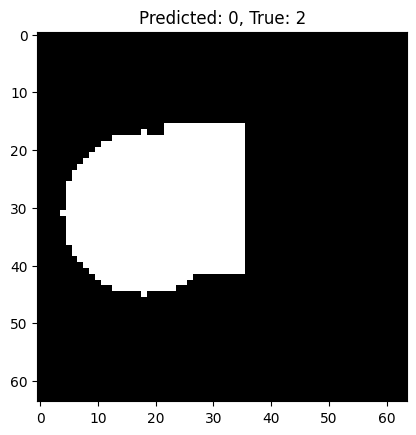

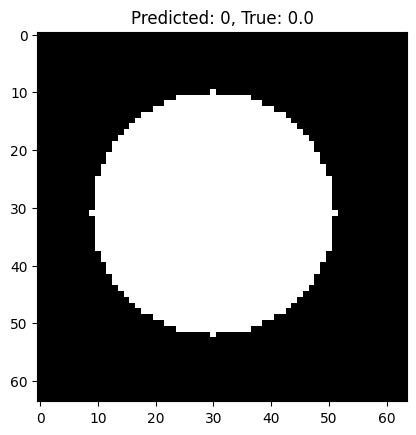

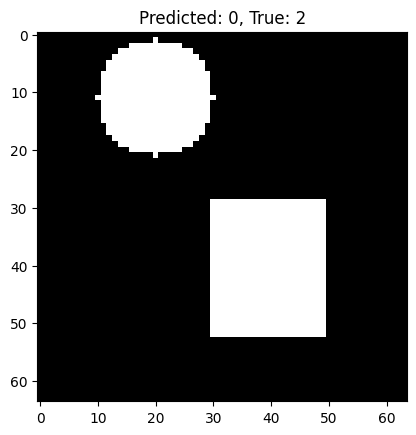

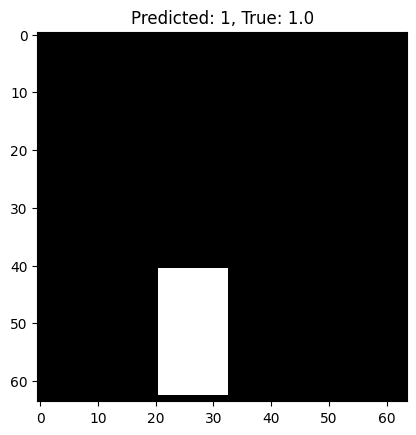

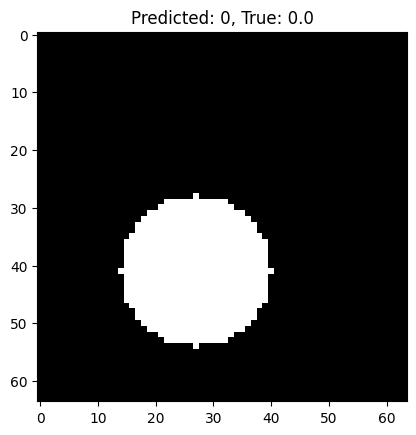

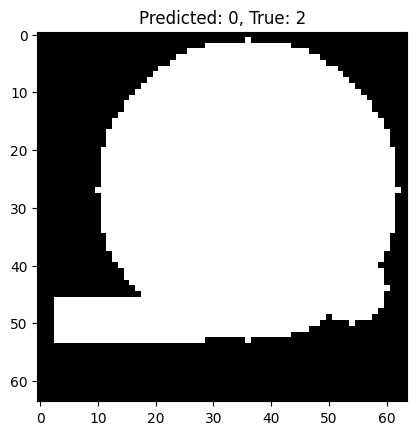

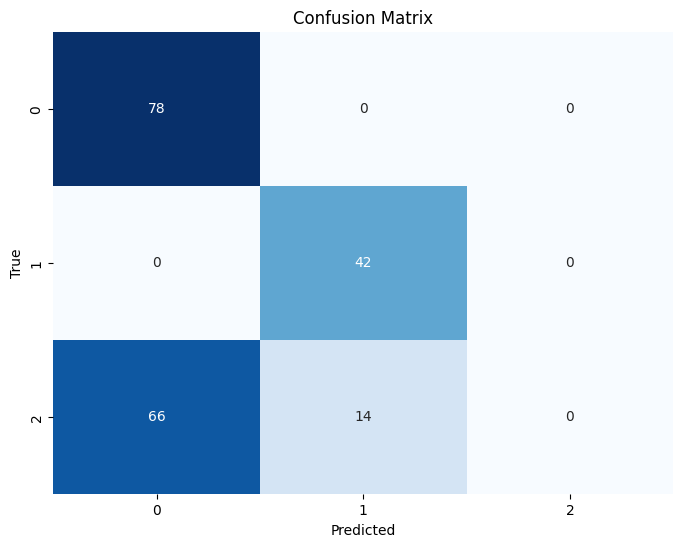

In [ ]:
# prompt: create inference and visualize model performance on new test set

import numpy as np
# Assuming the model and training process are complete as in the previous code.

# Create a new test dataset
test_dataset = MultiShapeDataset(num_samples=200, max_objects=5)  # Adjust num_samples as needed
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

# Function to perform inference and collect predictions
def perform_inference(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images = images.to(device)
            labels[:, :, 0].cpu().numpy()
            outputs = model(images)
            predicted_labels = torch.argmax(outputs, dim=1)

            label_values = labels[:, :, 0].cpu().numpy()

            modified_labels = np.where((label_values == 0).any(axis=1) & (label_values == 1).any(axis=1), 2, label_values[:, 0])

            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(modified_labels)

    return np.array(predictions), np.array(true_labels)


# Perform inference on the test set
predictions, true_labels = perform_inference(model, test_loader)

# Calculate accuracy
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")


# Visualize some predictions (optional)
import matplotlib.pyplot as plt

# Example: Show the first 10 images with their predicted and true labels
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]
    label_values = np.array([obj[0] for obj in label])
    true_label = 2 if (0 in label_values and 1 in label_values) else label_values[0]
    predicted_label = predictions[i]
    plt.imshow(image.squeeze(), cmap='gray')  # Assuming grayscale images
    plt.title(f"Predicted: {predicted_label}, True: {true_label}")
    plt.show()


# Plot confusion matrix (optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# โมเดลตรวจจับวัตถุ (Object Detection)

## ทดลองทำความเข้าใจลักษณะของการเก็บข้อมูล

In [16]:
# Get one batch from the dataset
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Print the batch size
print("Batch size:", images.shape[0])

# Print the shape of the images and labels
print("Image shape:", images.shape)
print("Labels shape:", labels.shape)
class_only=labels[:,:,0]
print('class_only: ',class_only)
print('class_only.shape: ',class_only.shape)

Batch size: 32
Image shape: torch.Size([32, 1, 64, 64])
Labels shape: torch.Size([32, 5, 5])
class_only:  tensor([[ 1., -1., -1., -1., -1.],
        [ 1.,  0., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 0.,  1., -1., -1., -1.],
        [ 0.,  1.,  0., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 0.,  0., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 1.,  1.,  1., -1., -1.],
        [ 0.,  0., -1., -1., -1.],
        [ 0.,  1., -1., -1., -1.],
        [ 0.,  0., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 0.,  1., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 1., -1., -1., -1., -1.],
        [ 0.,  0., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 1.,  1., -1., -1., -1.],
        [ 0.,  0., -1., -1., -1.],
        [ 0.,  1., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 0., -1., -1., -1., -1.],
        [ 0.,  0., 

In [17]:
class_onehot = torch.ones(class_only.shape[0], class_only.shape[1], 2, dtype=torch.int64) # Changed dtype to torch.int64 or torch.long

class_onehot[class_only == 1] = torch.tensor([0, 1], dtype=torch.int64) #  Ensure source tensor dtype matches destination
class_onehot[class_only == 0] = torch.tensor([1, 0], dtype=torch.int64) #  Ensure source tensor dtype matches destination
print('class_onehot: ',class_onehot)
print('class_onehot[:,0,:]: ',class_onehot[:,0,:])

class_onehot:  tensor([[[0, 1],
         [1, 1],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[0, 1],
         [1, 0],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [1, 1],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [0, 1],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [0, 1],
         [1, 0],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [1, 1],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [1, 0],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [1, 1],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[0, 1],
         [0, 1],
         [0, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [1, 0],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [0, 1],
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [1

In [18]:
box_only=labels[:,:,1:]
print('box_only.shape: ',box_only.shape)
print('box_only: ',box_only)
print('box_only.reshape((32,20)): ',box_only.reshape((32,20)))

box_only.shape:  torch.Size([32, 5, 4])
box_only:  tensor([[[0.5469, 0.5469, 0.2969, 0.2188],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.4844, 0.5000, 0.3906, 0.3750],
         [0.2500, 0.3594, 0.3125, 0.3125],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.3438, 0.4844, 0.5938, 0.5938],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.5000, 0.5156, 0.8125, 0.8125],
         [0.8281, 0.7344, 0.2969, 0.1719],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.6719, 0.3125, 0.5938, 0.5938],
         [0.2344, 0.5312, 0.3906, 0.32

## Training function

In [19]:
def train_object_detection_model(model, train_loader, class_loss_fn, bbox_loss_fn, optimizer, num_epochs=20):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # labels shape = (batch_size, num_objects, 5)
            #   columns: (class, x, y, w, h)

            optimizer.zero_grad()

            # 1) Forward
            outputs = model(inputs)
            # 'outputs' shape = [batch_size, 30]  (ตามที่ num_classes=30 กำหนดในโมเดล)
            #   - ส่วนหน้า 10 สำหรับ class prediction (5 objects × 2 classes/object)
            #   - ส่วนหลัง 20 สำหรับ bbox (5 objects × 4 ค่า/object)

            # 2) แยก Class Prediction กับ BBox Prediction
            class_preds = outputs[:, :10]  # 0~9 (B, 10)
            bbox_preds = outputs[:, 10:]   # 10~29 (B, 20)

            # 3) เตรียม Label สำหรับ Class
            class_labels = labels[:, :, 0]  # (B, num_objects=5)
            # class_labels = 0 หรือ 1
            # สร้าง one-hot สำหรับแต่ละ object (5 objects) โดยแต่ละ object มี 2 classes (binary)
            # => class_onehot shape = [B, 5, 2]

            class_onehot = torch.ones(class_labels.shape[0], class_labels.shape[1], 2, dtype=torch.float)
            # class_onehot[class_labels == 1] = [0, 1]
            # class_onehot[class_labels == 0] = [1, 0]

            class_onehot[class_labels == 1] = torch.tensor([0, 1], dtype=torch.float)
            class_onehot[class_labels == 0] = torch.tensor([1, 0], dtype=torch.float)
            class_onehot = class_onehot.to(device)

            # 4) คำนวณ Class Loss โดยใช้ CrossEntropyLoss 5 ชุด สำหรับ 5 objects
            #   - ตัวอย่างในโค้ดใช้ fn (nn.functional.softmax + Loss) ของแต่ละ object แยกกัน
            #   - แล้วบวกกันทุก object
            class_loss = class_loss_fn[0](nn.functional.softmax(class_preds[:, 0:2], dim=1),
                                          class_onehot[:, 0, :]) \
                       + class_loss_fn[1](nn.functional.softmax(class_preds[:, 2:4], dim=1),
                                          class_onehot[:, 1, :]) \
                       + class_loss_fn[2](nn.functional.softmax(class_preds[:, 4:6], dim=1),
                                          class_onehot[:, 2, :]) \
                       + class_loss_fn[3](nn.functional.softmax(class_preds[:, 6:8], dim=1),
                                          class_onehot[:, 3, :]) \
                       + class_loss_fn[4](nn.functional.softmax(class_preds[:, 8:10], dim=1),
                                          class_onehot[:, 4, :])

            # 5) เตรียม Label สำหรับ Bounding Box
            #    bbox_preds = (B, 20) => แบ่งเป็น 5 objects × 4 ค่า/ object
            #    labels[:,:,1:] = (B, 5, 4) => reshape => (B, 20)
            #    โดย x, y, w, h จะเทียบกันด้วย MSE
            #    (สมมติว่าข้อมูล normalized ไว้แล้ว)
            bbox_loss = bbox_loss_fn(
                nn.functional.sigmoid(bbox_preds),         # (B, 20)
                labels[:, :, 1:].reshape((labels.shape[0], 20))  # (B, 20)
            )

            # 6) รวม Loss
            #    - แบ่งถ่วงน้ำหนัก (เช่น class_loss / 5 เพื่อเฉลี่ย 5 objects)
            #    - บวก bbox_loss × 2 เพื่อเพิ่มความสำคัญ
            total_loss = class_loss / 5 + 2 * bbox_loss

            # 7) Backpropagation
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

1. ฟังก์ชัน train_object_detection_model:
 * วนลูป Epoch -> วนลูป Batch -> Forward -> แบ่ง Outputs เป็น Class และ BBox -> สร้าง One-hot label -> คำนวณ CrossEntropyLoss 5 objects -> คำนวณ BBox Loss (MSE) -> รวม Loss -> Backward & Update
2. การที่ output ของโมเดลมี 30 มิติ ก็เพราะในตัวอย่างนี้ออกแบบให้:
 * 10 มิติสำหรับ 5 objects × 2 classes (Binary Classification ต่อ object)
 * 20 มิติสำหรับ 5 objects × 4 ค่า bounding box
3. ตัวอย่างการคำนวณ loss สำหรับ “class” ทำแบบแมนนวล (softmax ทีละ 2 ช่อง แล้ว compare กับ one-hot) ซึ่งสามารถปรับปรุงให้ยืดหยุ่นมากขึ้นได้
4. การถ่วงน้ำหนัก class_loss และ bbox_loss (เช่น /5 และ ×2) เป็นการปรับค่า hyperparameter เพื่อให้ความสำคัญไม่เท่ากัน
5. ในการนำไปใช้งานจริง ต้องแน่ใจว่า label ของ bounding box ถูกจัดรูปแบบและ normalized ตามที่โมเดล output คาดหวัง และระวังการซ้อนทับ channel/มิติของ class

In [22]:
object_detection_model = ResNetwithAttention_nano(im_channels=1,num_classes=30)
print(f"Total trainable parameters: {count_parameters(object_detection_model)}")
# Define the loss functions
class_loss_fn = [nn.CrossEntropyLoss(),
                 nn.CrossEntropyLoss(),
                 nn.CrossEntropyLoss(),
                 nn.CrossEntropyLoss(),
                 nn.CrossEntropyLoss()]  # ใช้ CrossEntropyLoss 5 ชุด สำหรับ 5 objects
bbox_loss_fn = nn.MSELoss()  # ใช้ MSELoss สำหรับ bbox
optimizer = optim.Adam(object_detection_model.parameters(), lr=0.001)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# Train the model
train_object_detection_model(object_detection_model, train_loader,class_loss_fn,bbox_loss_fn,optimizer, num_epochs=20)

Total trainable parameters: 606473
Epoch 1, Loss: 1.3213
Epoch 2, Loss: 1.1257
Epoch 3, Loss: 1.0910
Epoch 4, Loss: 1.0791
Epoch 5, Loss: 1.0687
Epoch 6, Loss: 1.0591
Epoch 7, Loss: 1.0584
Epoch 8, Loss: 1.0540
Epoch 9, Loss: 1.0528
Epoch 10, Loss: 1.0513
Epoch 11, Loss: 1.0512
Epoch 12, Loss: 1.0468
Epoch 13, Loss: 1.0504
Epoch 14, Loss: 1.0463
Epoch 15, Loss: 1.0507
Epoch 16, Loss: 1.0473
Epoch 17, Loss: 1.0465
Epoch 18, Loss: 1.0471
Epoch 19, Loss: 1.0456
Epoch 20, Loss: 1.0428


# Lab10.3 ปรับการคำนวณ Class Loss ให้เป็นแบบทั่วไป
เป้าหมาย: ปรับโค้ดเพื่อไม่ต้องเขียน softmax และ slicing ทีละ 2 ค่าด้วยตนเอง
1. ปัจจุบัน โค้ดแบ่ง class_preds[:, 0:2], class_preds[:, 2:4], ... แล้วใช้ nn.functional.softmax และ CrossEntropyLoss ทีละ object
2. ลองจัด class_preds ให้มี shape [B, num_objects, 2] เช่น
```python
class_preds = outputs[:, :10].reshape(-1, 5, 2)  # (B, 5, 2)e
```
3. ตกลงว่า label class จะเป็น integer (0 หรือ 1) แล้วใช้ nn.CrossEntropyLoss() เพียงครั้งเดียว
```
# สมมติ reshape class_labels เป็น (B, 5) -> flatten => (B*5,)
# flatten class_preds => (B*5, 2)
# class_loss = cross_entropy_loss(class_preds.view(-1, 2), class_labels.view(-1))
```
4. เปรียบเทียบผลลัพธ์กับการเขียนสไตล์ “บวกหลาย ๆ CrossEntropyLoss”

**คำถาม:**
1. Lab10.3.1 แบบใดเขียนโค้ดง่ายกว่ากัน และให้ผลลัพธ์ต่างกันหรือไม่?
2. Lab10.3.2 ถ้าเป็น multi-class (มากกว่า 2 คลาสต่อ object) สามารถปรับได้ง่ายขึ้นไหม?

In [9]:
import torch
import torch.nn as nn

def train_object_detection_model(model, train_loader, class_loss_fn, bbox_loss_fn, optimizer, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Class Predictions: Shape (B, 5, 2)
            class_preds = outputs[:, :10].reshape(-1, 2)  # Flatten to (B*5, 2)

            # Class Labels: Shape (B, 5) -> Flatten to (B*5,)
            class_labels = labels[:, :, 0].reshape(-1).long()

            # คำนวณ CrossEntropyLoss โดยข้ามค่า -1 อัตโนมัติ
            valid_mask = class_labels != -1
            class_loss = class_loss_fn(class_preds[valid_mask], class_labels[valid_mask]) if valid_mask.any() else torch.tensor(0.0, device=device)

            # Bounding Box Predictions
            bbox_preds = torch.sigmoid(outputs[:, 10:])  # (B, 20)
            bbox_targets = labels[:, :, 1:].reshape(labels.shape[0], 20)  # (B, 20)

            bbox_loss = bbox_loss_fn(bbox_preds, bbox_targets)

            # รวม Loss
            total_loss = class_loss + 2 * bbox_loss

            # Backpropagation
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.detach().item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# ฟังก์ชันนับพารามิเตอร์ของโมเดล
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# สร้างโมเดล
object_detection_model = ResNetwithAttention_nano(im_channels=1, num_classes=30)
print(f"Total trainable parameters: {count_parameters(object_detection_model)}")

model = object_detection_model

# กำหนด Loss Functions
class_loss_fn = nn.CrossEntropyLoss()  # ใช้ตัวเดียวสำหรับทุก object
bbox_loss_fn = nn.MSELoss()  # ใช้ MSELoss สำหรับ bbox

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_object_detection_model(model, train_loader, class_loss_fn, bbox_loss_fn, optimizer, num_epochs=20)

Total trainable parameters: 606473
Epoch 1, Loss: 0.7013
Epoch 2, Loss: 0.5092
Epoch 3, Loss: 0.4311
Epoch 4, Loss: 0.3865
Epoch 5, Loss: 0.3737
Epoch 6, Loss: 0.3562
Epoch 7, Loss: 0.3367
Epoch 8, Loss: 0.3294
Epoch 9, Loss: 0.3203
Epoch 10, Loss: 0.3208
Epoch 11, Loss: 0.3111
Epoch 12, Loss: 0.3016
Epoch 13, Loss: 0.3029
Epoch 14, Loss: 0.3100
Epoch 15, Loss: 0.2996
Epoch 16, Loss: 0.3053
Epoch 17, Loss: 0.2848
Epoch 18, Loss: 0.2835
Epoch 19, Loss: 0.2827
Epoch 20, Loss: 0.2762


In [16]:
# Create a new test dataset
test_dataset = MultiShapeDataset(num_samples=200, max_objects=5)  # Adjust num_samples as needed
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

Test Accuracy: 0.318


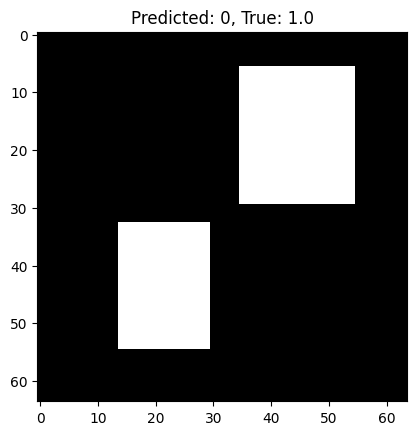

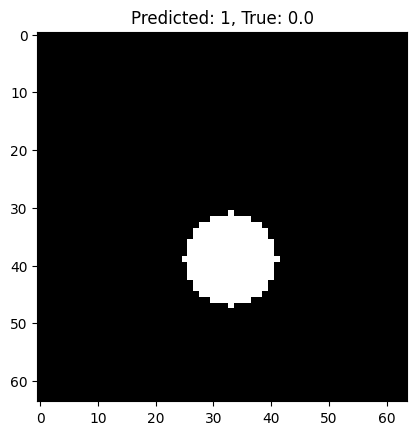

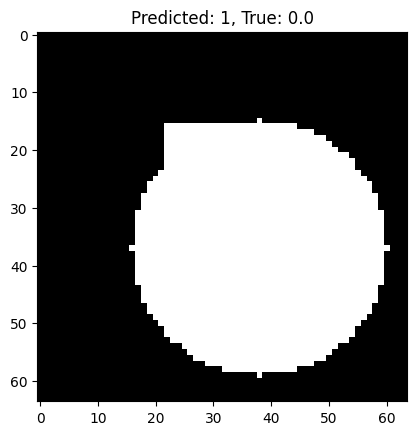

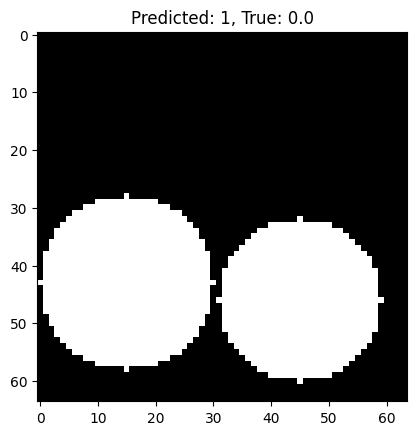

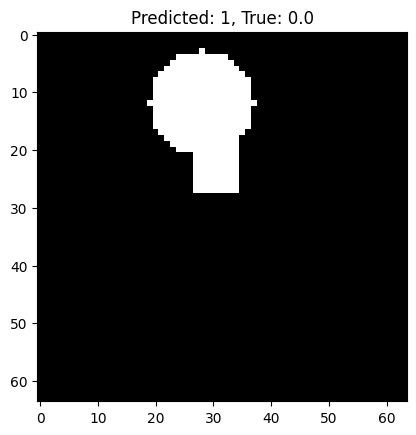

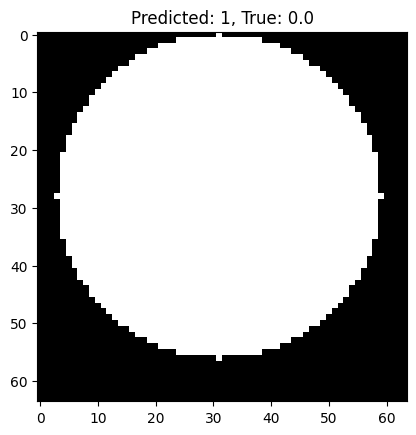

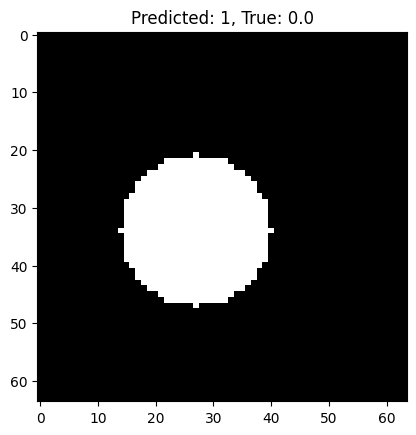

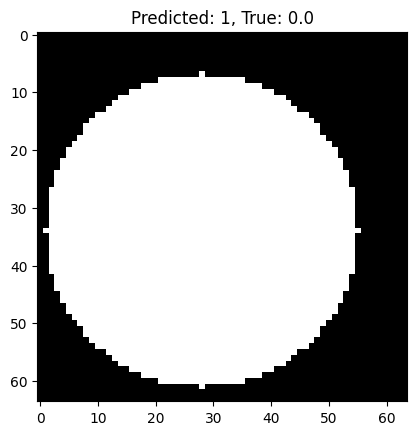

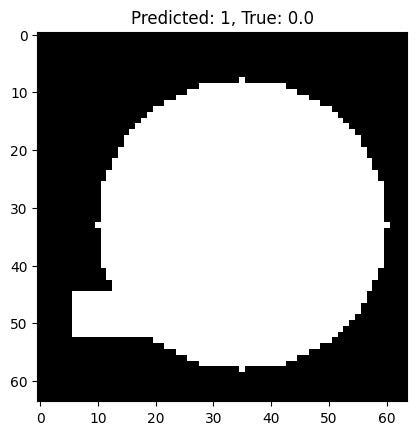

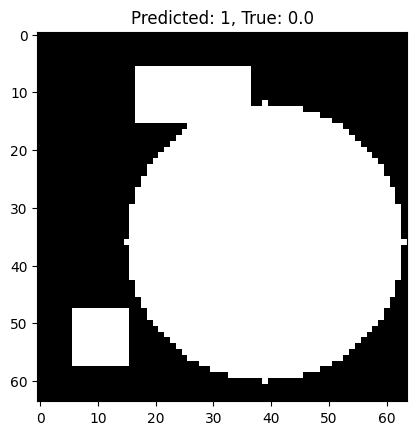

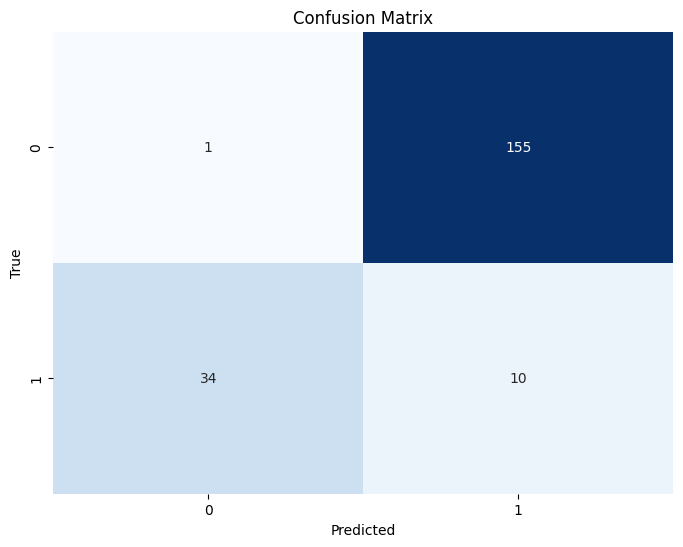

In [17]:
# prompt: create inference and visualize model performance on new test set

import numpy as np
# Assuming the model and training process are complete as in the previous code.

# Function to perform inference and collect predictions
def perform_inference(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            predicted_labels = (outputs > 0.5).int()  # Convert probabilities to binary predictions
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels[:,0][:,0].unsqueeze(1).cpu().numpy())
    return np.array(predictions), np.array(true_labels)


# Perform inference on the test set
predictions, true_labels = perform_inference(model, test_loader)

# Reshape predictions to be binary (select the first class prediction)
predictions = predictions[:, 0]  # Assuming the first column represents the main class

# Calculate accuracy
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")


# Visualize some predictions (optional)
import matplotlib.pyplot as plt

# Example: Show the first 10 images with their predicted and true labels
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]
    predicted_label = predictions[i]
    plt.imshow(image.squeeze(), cmap='gray')  # Assuming grayscale images
    plt.title(f"Predicted: {predicted_label}, True: {label[0][0]}")
    plt.show()


# Plot confusion matrix (optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Test Accuracy: 0.575


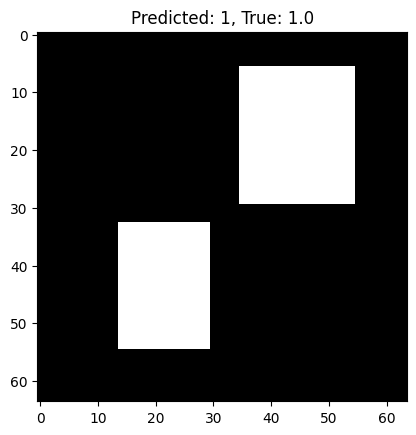

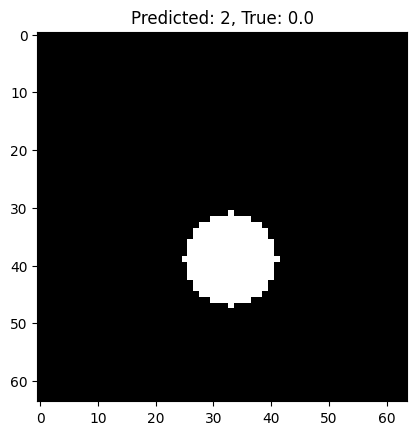

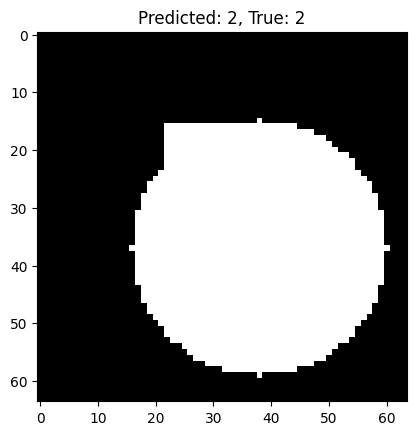

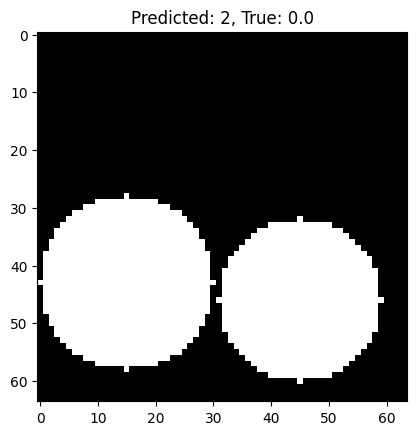

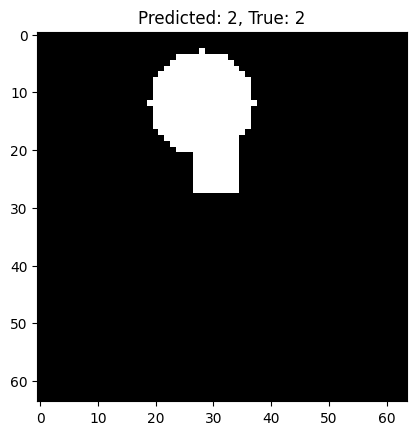

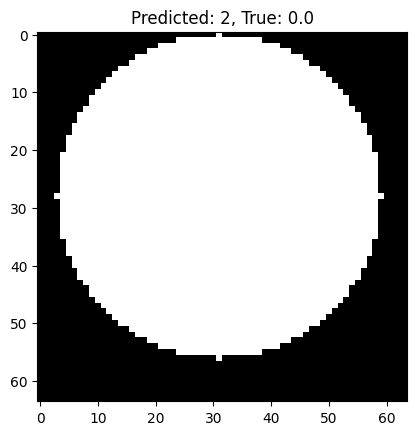

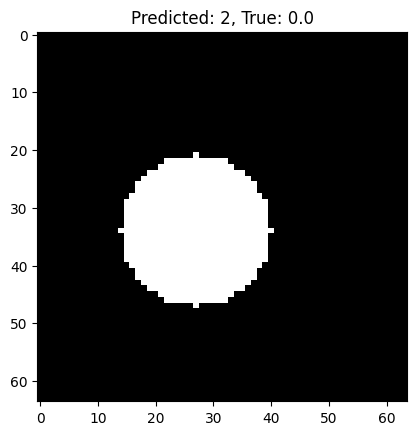

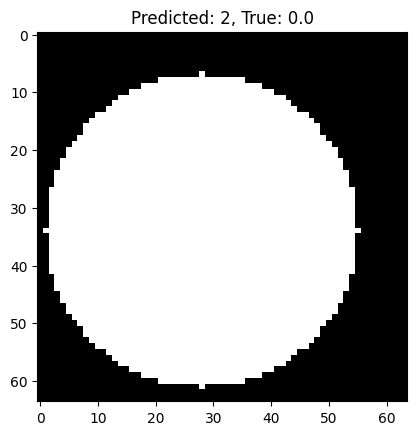

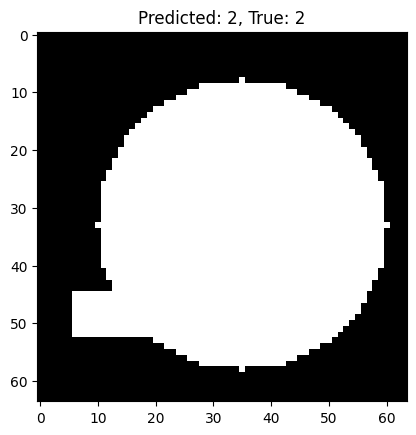

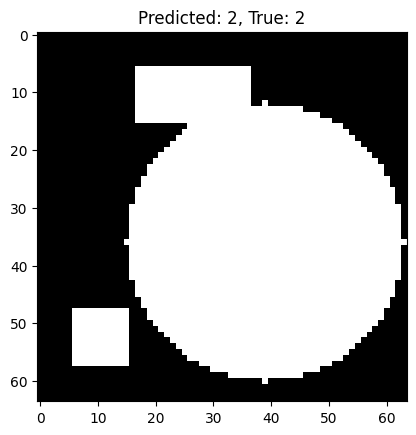

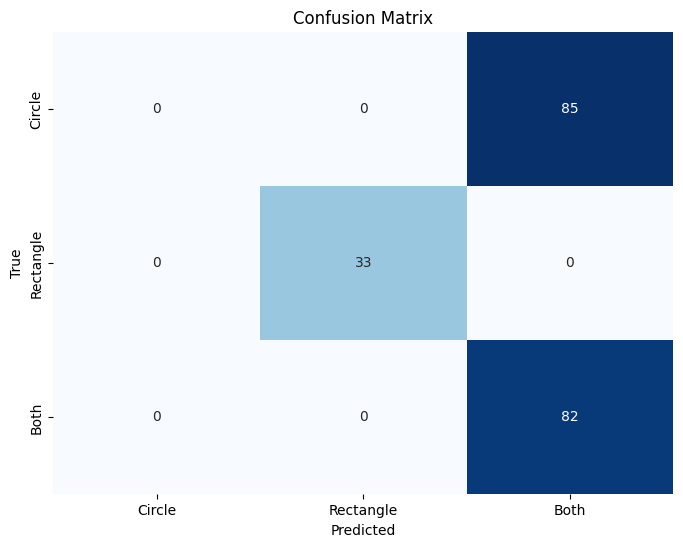

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter

# ฟังก์ชันสำหรับ inference
def perform_inference(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)  # Shape: (B, 10)

            # Reshape outputs to (B, 5, 2) แล้วเลือก class ที่มีค่ามากที่สุด
            class_preds = outputs[:, :10].reshape(-1, 5, 2).argmax(dim=2).cpu().numpy()  # (B, 5)

            # ดึงค่า label class ของ object
            label_values = labels[:, :, 0].cpu().numpy()  # (B, 5)

            # สร้าง modified_labels โดยใช้ mode ของ class object ในภาพนั้น ๆ
            modified_labels = np.array([
                2 if (0 in lbls and 1 in lbls) else Counter(lbls[lbls != -1]).most_common(1)[0][0]
                for lbls in label_values
            ])

            # สร้าง predicted_labels โดยใช้ mode ของ class object ที่ model ทำนาย
            predicted_labels = np.array([
                2 if (0 in preds and 1 in preds) else Counter(preds).most_common(1)[0][0]
                for preds in class_preds
            ])

            predictions.extend(predicted_labels)
            true_labels.extend(modified_labels)

    return np.array(predictions), np.array(true_labels)

# ทำ inference
predictions, true_labels = perform_inference(model, test_loader)

# คำนวณ accuracy
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")

# แสดงภาพพร้อมค่าทำนาย
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]

    # คำนวณ label ใหม่แบบเดียวกับใน perform_inference
    label_values = np.array([obj[0] for obj in label])
    true_label = 2 if (0 in label_values and 1 in label_values) else Counter(label_values[label_values != -1]).most_common(1)[0][0]

    predicted_label = predictions[i]

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_label}, True: {true_label}")
    plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Circle', 'Rectangle', 'Both'],
            yticklabels=['Circle', 'Rectangle', 'Both'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# prompt: create a function to return row and column from class_preds that value more than 0.6

def get_rows_cols_above_threshold(class_preds, threshold=0.6):
  """
  Returns the row and column indices where the values in class_preds are above the specified threshold.

  Args:
    class_preds: A list of PyTorch tensors, each representing class probabilities.
    threshold: The threshold value.

  Returns:
    A list of tuples, where each tuple contains the row and column indices of values above the threshold.
  """
  results = []
  for i, preds in enumerate(class_preds):
    rows, cols = torch.where(preds > threshold)
    for row, col in zip(rows, cols):
      results.append((i, row, col)) #Store the tensor index, row, and column
  return results


In [20]:
# prompt: write a function to get xywh from bbox_preds given box index

def get_xywh_from_bbox_preds(bbox_preds, box_index):

    num_boxes = bbox_preds.shape[1] // 4  # Calculate the number of boxes
    if not (0 <= box_index < num_boxes):
        print("Error: Box index is out of range.")
        return None

    start_index = box_index * 4
    end_index = start_index + 4
    xywh = bbox_preds[0, start_index:end_index].numpy() # Accessing the first element in batch dimension

    return xywh


In [21]:
# prompt: call get_rows_cols_above_threshold and get_xywh_from_bbox_preds

# Assuming you have 'class_preds' and 'bbox_preds' tensors available.
# Example usage:
class_preds = [torch.rand(5, 2), torch.rand(5, 2)] # Example class predictions
bbox_preds = torch.rand(1, 20) # Example bounding box predictions

# Call get_rows_cols_above_threshold
rows_cols_above_threshold = get_rows_cols_above_threshold(class_preds, threshold=0.6)
print("rows_cols_above_threshold:", rows_cols_above_threshold)

# Call get_xywh_from_bbox_preds with a valid box_index
box_index = 0 # Choose a valid box index
xywh = get_xywh_from_bbox_preds(bbox_preds, box_index)
if xywh is not None:
  print(f"Bounding box coordinates (x, y, w, h) for box {box_index}:", xywh)


rows_cols_above_threshold: [(0, tensor(0), tensor(0)), (0, tensor(2), tensor(0)), (0, tensor(3), tensor(0)), (0, tensor(3), tensor(1)), (1, tensor(0), tensor(0)), (1, tensor(1), tensor(1)), (1, tensor(3), tensor(0)), (1, tensor(4), tensor(0))]
Bounding box coordinates (x, y, w, h) for box 0: [0.01640385 0.9934212  0.43993527 0.70161897]


# Segmentation

In [23]:
class MultiShapeSegmentationDatasetFromMultiShape(Dataset):
    def __init__(self, multi_shape_dataset):
        """
        Args:
            multi_shape_dataset (Dataset): An instance of MultiShapeDataset.
        """
        self.multi_shape_dataset = multi_shape_dataset
        self.image_size = multi_shape_dataset.image_size  # (width, height)
        self.max_objects = multi_shape_dataset.max_objects

    def __len__(self):
        return len(self.multi_shape_dataset)

    def __getitem__(self, idx):
        # Get the original image and labels from the MultiShapeDataset.
        # img: Tensor of shape [1, H, W]
        # labels: Tensor of shape [max_objects, 5] where each label is [class, x, y, w, h]
        img, labels = self.multi_shape_dataset[idx]

        # Convert labels to NumPy for easier processing.
        # (Alternatively, you can work with tensors.)
        labels_np = labels.numpy()
        W, H = self.image_size  # image_size is (width, height)

        # Create an empty segmentation mask (background = 0).
        seg_mask = np.zeros((H, W), dtype=np.int64)

        # Iterate over each label.
        for label in labels_np:
            cls = int(label[0])
            # Skip dummy labels.
            if cls == -1:
                continue

            # Define segmentation class:
            # 1 for circle (original cls==0), 2 for rectangle (original cls==1)
            seg_class = 1 if cls == 0 else 2

            # Convert normalized coordinates to absolute pixel values.
            center_x = int(label[1] * W)
            center_y = int(label[2] * H)
            box_w = int(label[3] * W)
            box_h = int(label[4] * H)

            if cls == 0:
                # For a circle, assume the bounding box is a square: use half the width as radius.
                # (The original drawing sets the circle's diameter to 2*r.)
                radius = box_w // 2  # or box_h // 2; for a circle they should be equal.
                # Create a meshgrid of coordinates.
                yy, xx = np.ogrid[:H, :W]
                # Generate a circular mask: pixels within the circle are True.
                circle_mask = (xx - center_x) ** 2 + (yy - center_y) ** 2 <= radius ** 2
                seg_mask[circle_mask] = seg_class

            else:
                # For a rectangle, compute the corner coordinates.
                x1 = max(0, center_x - box_w // 2)
                x2 = min(W, center_x + box_w // 2)
                y1 = max(0, center_y - box_h // 2)
                y2 = min(H, center_y + box_h // 2)
                # Fill the rectangular area.
                seg_mask[y1:y2, x1:x2] = seg_class

        # Return the original image and the generated segmentation mask.
        # The segmentation mask is converted to a torch tensor.
        return img, torch.tensor(seg_mask, dtype=torch.long)

In [24]:
class SegmentationModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        """
        Args:
            in_channels (int): Number of input channels (e.g., 1 for grayscale images).
            num_classes (int): Number of segmentation classes (e.g., 3 for background, circle, rectangle).
        """
        super(SegmentationModel, self).__init__()

        # Encoder
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc1 = ResidualBlock(64, 64)         # Feature map: 64 channels, same resolution.
        self.pool1 = nn.MaxPool2d(2)              # Downsample by a factor of 2.
        self.enc2 = ResidualBlock(64, 128)         # Feature map: 128 channels.
        self.attention = CBAMAttention(128)        # Apply CBAM-like attention on encoder features.
        self.pool2 = nn.MaxPool2d(2)              # Further downsample.
        self.enc3 = ResidualBlock(128, 256)        # Feature map: 256 channels.

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsample.
        # After upsampling, we concatenate with encoder block enc2 (128 channels), giving 128+128=256 channels.
        self.dec1 = ResidualBlock(256, 128)         # Reduce back to 128 channels.
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # Upsample.
        # Concatenate with encoder block enc1 (64 channels): 64+64=128 channels.
        self.dec2 = ResidualBlock(128, 64)          # Reduce back to 64 channels.
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)  # Final 1×1 convolution for segmentation.

    def forward(self, x):
        # Encoder
        x0 = self.initial_conv(x)      # [B, 64, H, W]
        x1 = self.enc1(x0)             # [B, 64, H, W]
        x2 = self.pool1(x1)            # [B, 64, H/2, W/2]
        x3 = self.enc2(x2)             # [B, 128, H/2, W/2]
        x3 = self.attention(x3)        # [B, 128, H/2, W/2] after attention.
        x4 = self.pool2(x3)            # [B, 128, H/4, W/4]
        x5 = self.enc3(x4)             # [B, 256, H/4, W/4]

        # Decoder
        u1 = self.up1(x5)              # [B, 128, H/2, W/2]
        # Concatenate skip connection from x3.
        cat1 = torch.cat([u1, x3], dim=1)  # [B, 256, H/2, W/2]
        d1 = self.dec1(cat1)           # [B, 128, H/2, W/2]
        u2 = self.up2(d1)              # [B, 64, H, W]
        # Concatenate skip connection from x1.
        cat2 = torch.cat([u2, x1], dim=1)  # [B, 128, H, W]
        d2 = self.dec2(cat2)           # [B, 64, H, W]
        out = self.final_conv(d2)      # [B, num_classes, H, W]
        return out

In [25]:
def train_segmentation_model(model, dataloader, optimizer, criterion, device, num_epochs=20):
    """
    Trains the segmentation model.

    Args:
        model (nn.Module): The segmentation model.
        dataloader (DataLoader): DataLoader for the training dataset.
        optimizer (torch.optim.Optimizer): The optimizer.
        criterion (nn.Module): Loss function (e.g., nn.CrossEntropyLoss()).
        device (torch.device): Device to run training on.
        num_epochs (int): Number of epochs to train.
    """
    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode.
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move data to device
            inputs = inputs.to(device)       # [B, in_channels, H, W]
            targets = targets.to(device)     # [B, H, W], where each pixel is a class index.

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)          # [B, num_classes, H, W]

            # Compute loss: CrossEntropyLoss expects outputs of shape [B, num_classes, H, W]
            # and targets of shape [B, H, W] with class indices.
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


In [ ]:
multi_shape_dataset = MultiShapeDataset(num_samples=1000, max_objects=5)

    # Create the segmentation dataset by wrapping the original dataset.
seg_dataset = MultiShapeSegmentationDatasetFromMultiShape(multi_shape_dataset)

model = SegmentationModel(in_channels=1, num_classes=3)

    # Create a DataLoader for the segmentation dataset.
    # Here, batch_size is chosen arbitrarily; adjust as needed.
train_loader = DataLoader(seg_dataset, batch_size=16, shuffle=True, num_workers=2)

    # Define the optimizer.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Define the loss function.
criterion = nn.CrossEntropyLoss()

    # Set the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train the model.
train_segmentation_model(model, train_loader, optimizer, criterion, device, num_epochs=20)

Epoch [1/20], Loss: 0.1025
Epoch [2/20], Loss: 0.0289
Epoch [3/20], Loss: 0.0196
Epoch [4/20], Loss: 0.0218
Epoch [5/20], Loss: 0.0159
Epoch [6/20], Loss: 0.0139
Epoch [7/20], Loss: 0.0143
Epoch [8/20], Loss: 0.0161
Epoch [9/20], Loss: 0.0129
Epoch [10/20], Loss: 0.0113
Epoch [11/20], Loss: 0.0097
Epoch [12/20], Loss: 0.0097
Epoch [13/20], Loss: 0.0105
Epoch [14/20], Loss: 0.0101
Epoch [15/20], Loss: 0.0092
Epoch [16/20], Loss: 0.0082
Epoch [17/20], Loss: 0.0077
Epoch [18/20], Loss: 0.0076
Epoch [19/20], Loss: 0.0081
Epoch [20/20], Loss: 0.0074


In [26]:
#########################################
# Helper Function: Compute IoU per Class
#########################################
def compute_iou_per_class(pred, target, num_classes):
    """
    Compute Intersection-over-Union for each class.
    Args:
        pred: NumPy array of shape [H, W] with predicted class labels.
        target: NumPy array of shape [H, W] with ground-truth labels.
        num_classes: Integer, number of classes.
    Returns:
        iou_per_class: List of IoU values per class.
    """
    iou_per_class = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()
        if union == 0:
            iou = float('nan')  # Class not present in GT and/or pred.
        else:
            iou = intersection / union
        iou_per_class.append(iou)
    return iou_per_class

#########################################
# Evaluation Function for Segmentation
#########################################
def evaluate_segmentation_model(model, dataloader, device, num_classes):
    """
    Runs inference on the test dataset and computes pixel accuracy and mean IoU.

    Args:
        model (nn.Module): The segmentation model.
        dataloader (DataLoader): Yields (images, seg_masks) where:
            - images: Tensor of shape [B, 1, H, W]
            - seg_masks: Tensor of shape [B, H, W] with integer class labels.
        device (torch.device): Device for computation.
        num_classes (int): Number of segmentation classes.
    """
    model.to(device)
    model.eval()

    total_correct = 0
    total_pixels = 0
    iou_accumulator = np.zeros(num_classes)
    valid_class_counts = np.zeros(num_classes)

    with torch.no_grad():
        for images, seg_masks in dataloader:
            images = images.to(device)             # [B, 1, H, W]
            seg_masks = seg_masks.to(device)         # [B, H, W]
            outputs = model(images)                  # [B, num_classes, H, W]
            predictions = torch.argmax(outputs, dim=1)  # [B, H, W]

            # Pixel-wise accuracy.
            correct = (predictions == seg_masks).sum().item()
            total = torch.numel(seg_masks)
            total_correct += correct
            total_pixels += total

            # Compute IoU per class for each image in the batch.
            preds_np = predictions.cpu().numpy()
            gt_np = seg_masks.cpu().numpy()
            B = preds_np.shape[0]
            for b in range(B):
                iou_per_cls = compute_iou_per_class(preds_np[b], gt_np[b], num_classes)
                for cls in range(num_classes):
                    # Only count if ground truth has this class.
                    if np.sum(gt_np[b] == cls) > 0:
                        if not np.isnan(iou_per_cls[cls]):
                            iou_accumulator[cls] += iou_per_cls[cls]
                            valid_class_counts[cls] += 1

    pixel_accuracy = total_correct / total_pixels
    mean_iou = np.nanmean([iou_accumulator[cls] / (valid_class_counts[cls] + 1e-6)
                           if valid_class_counts[cls] > 0 else float('nan')
                           for cls in range(num_classes)])

    print(f"Pixel Accuracy: {pixel_accuracy * 100:.2f}%")
    print(f"Mean IoU: {mean_iou:.4f}")

    return pixel_accuracy, mean_iou

In [ ]:
test_dataset = MultiShapeDataset(num_samples=100, max_objects=5)

test_object_dataset=MultiShapeSegmentationDatasetFromMultiShape(test_dataset)
test_dataloader = DataLoader(
        test_object_dataset, batch_size=16, shuffle=False, num_workers=num_workers
    )

In [ ]:
# Number of segmentation classes (for example: 0=background, 1=circle, 2=rectangle).
num_classes = 3
class_names = ["Background", "Circle", "Rectangle"]

# Evaluate the segmentation model.
evaluate_segmentation_model(model, test_dataloader, device, num_classes)


Pixel Accuracy: 99.26%
Mean IoU: 0.9554


(0.99256103515625, 0.9553712433519177)

In [27]:
#########################################
# Visualization Function for One Image
#########################################
def visualize_segmentation(model, dataloader, device, class_names=None):
    """
    Visualizes one sample from the test dataset along with:
      - The input image.
      - The ground-truth segmentation mask.
      - The predicted segmentation mask (via argmax over model outputs).
      - Each output mask (per class) from the model output.

    Args:
        model (nn.Module): The segmentation model.
        dataloader (DataLoader): DataLoader yielding (images, seg_masks).
        device (torch.device): Computation device.
        class_names (list or None): Optional list of class names for display.
                                    If provided, used for labeling the output masks.
    """
    model.to(device)
    model.eval()

    # Get one batch from the dataloader.
    images, seg_masks = next(iter(dataloader))
    images = images.to(device)        # [B, 1, H, W]
    seg_masks = seg_masks.to(device)  # [B, H, W]

    with torch.no_grad():
        outputs = model(images)         # [B, num_classes, H, W]
        predictions = torch.argmax(outputs, dim=1)  # [B, H, W]

    # Take the first image in the batch.
    image_np = images[0].cpu().squeeze(0).numpy()   # [H, W]
    gt_mask_np = seg_masks[0].cpu().numpy()           # [H, W]
    pred_mask_np = predictions[0].cpu().numpy()       # [H, W]
    output_masks = outputs[0].cpu().numpy()           # [num_classes, H, W]

    # ---------------------------
    # Figure 1: Overall Visualizations
    # ---------------------------
    fig1, axs1 = plt.subplots(1, 3, figsize=(18, 6))

    axs1[0].imshow(image_np, cmap='gray')
    axs1[0].set_title("Input Image")
    axs1[0].axis('off')

    cmap = 'jet'
    vmin = 0
    vmax = (len(class_names)-1) if class_names is not None else 2
    axs1[1].imshow(gt_mask_np, cmap=cmap, vmin=vmin, vmax=vmax)
    axs1[1].set_title("Ground Truth Mask")
    axs1[1].axis('off')

    axs1[2].imshow(pred_mask_np, cmap=cmap, vmin=vmin, vmax=vmax)
    axs1[2].set_title("Predicted Mask")
    axs1[2].axis('off')

    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Figure 2: Individual Output Masks (one per class)
    # ---------------------------
    num_classes = outputs.shape[1]
    # Create as many subplots as there are output channels.
    fig2, axs2 = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    # If there's only one channel, wrap it in a list for iteration.
    if num_classes == 1:
        axs2 = [axs2]

    for i in range(num_classes):
        ax = axs2[i]
        mask = output_masks[i]  # shape [H, W]
        im = ax.imshow(mask, cmap='gray')
        title = f"Output Mask - Class {i}"
        if class_names is not None and i < len(class_names):
            title = f"{class_names[i]} ({i})"
        ax.set_title(title)
        ax.axis('off')
        fig2.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

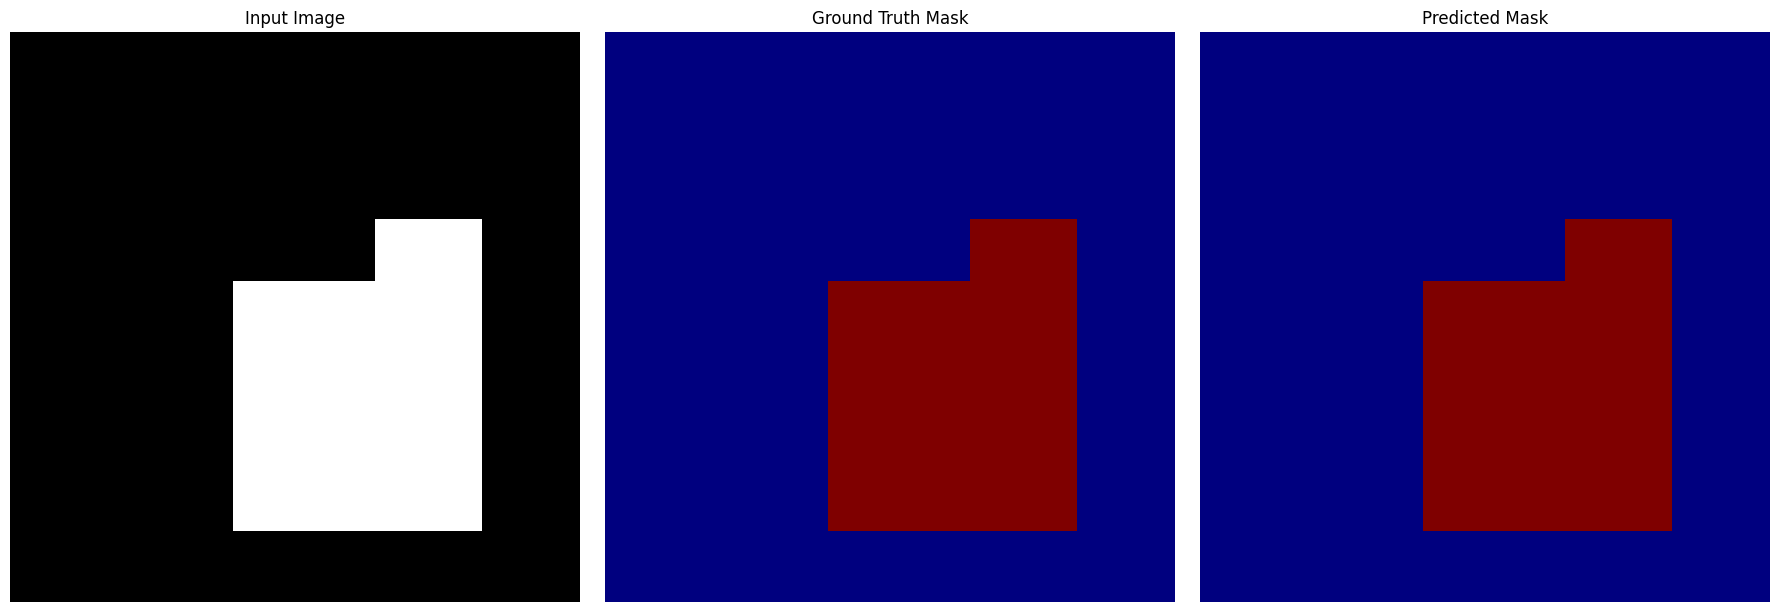

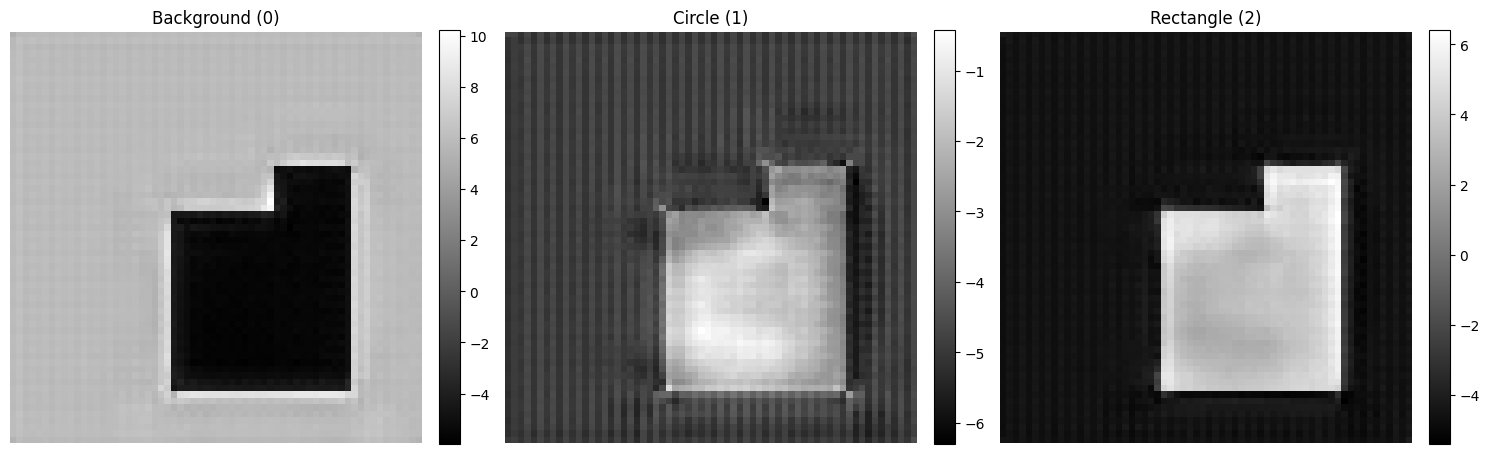

In [ ]:
# Visualize one sample from the test set.
visualize_segmentation(model, test_dataloader, device, class_names=class_names)

# **Lab10.4** เปลี่ยน Loss Function
ในตัวอย่างใช้ nn.CrossEntropyLoss() ซึ่งกำหนด target เป็น [B, H, W] พร้อมคลาส index
ให้ทดลองใช้ Dice Loss หรือ Focal Loss สำหรับงาน segmentation โดยเฉพาะ (อาจต้องแปลง Output หรือ Target เป็น one-hot)

In [22]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Convert targets to one-hot encoding (Assumes targets are integers)
        # targets: [B, H, W] -> targets_one_hot: [B, num_classes, H, W]
        num_classes = preds.shape[1]  # Get the number of classes from preds
        targets_one_hot = torch.nn.functional.one_hot(targets.long(), num_classes=num_classes).permute(0, 3, 1, 2).float()

        # Apply dice loss to each channel and then average
        dice_loss_per_channel = []
        for i in range(num_classes):  # Iterate over each class/channel
            # preds[:, i, :, :]: [B, H, W]
            # targets_one_hot[:, i, :, :]: [B, H, W]
            intersection = (preds[:, i, :, :] * targets_one_hot[:, i, :, :]).sum(dim=(1, 2))  # Sum over H and W
            union = preds[:, i, :, :].sum(dim=(1, 2)) + targets_one_hot[:, i, :, :].sum(dim=(1, 2))  # Sum over H and W
            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_loss_per_channel.append(1 - dice)  # 1 - dice for loss calculation

        # Average dice loss across all channels (classes)
        return torch.mean(torch.stack(dice_loss_per_channel))

In [28]:
multi_shape_dataset = MultiShapeDataset(num_samples=1000, max_objects=5)

    # Create the segmentation dataset by wrapping the original dataset.
seg_dataset = MultiShapeSegmentationDatasetFromMultiShape(multi_shape_dataset)

model = SegmentationModel(in_channels=1, num_classes=3)

    # Create a DataLoader for the segmentation dataset.
    # Here, batch_size is chosen arbitrarily; adjust as needed.
train_loader = DataLoader(seg_dataset, batch_size=16, shuffle=True, num_workers=2)

    # Define the optimizer.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Define the loss function.
criterion = DiceLoss(smooth=1e-5)

    # Set the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train the model.
train_segmentation_model(model, train_loader, optimizer, criterion, device, num_epochs=10)

Epoch [1/10], Loss: 0.7007
Epoch [2/10], Loss: 0.5550
Epoch [3/10], Loss: 0.7519
Epoch [4/10], Loss: 0.9681
Epoch [5/10], Loss: 0.7839
Epoch [6/10], Loss: 0.8735
Epoch [7/10], Loss: 0.8305
Epoch [8/10], Loss: 0.8140
Epoch [9/10], Loss: 0.8093
Epoch [10/10], Loss: 0.7815


In [29]:
test_dataset = MultiShapeDataset(num_samples=100, max_objects=5)

test_object_dataset=MultiShapeSegmentationDatasetFromMultiShape(test_dataset)
test_dataloader = DataLoader(
        test_object_dataset, batch_size=16, shuffle=False, num_workers=num_workers
    )

In [30]:
# Number of segmentation classes (for example: 0=background, 1=circle, 2=rectangle).
num_classes = 3
class_names = ["Background", "Circle", "Rectangle"]

# Evaluate the segmentation model.
evaluate_segmentation_model(model, test_dataloader, device, num_classes)

Pixel Accuracy: 53.85%
Mean IoU: 0.3922


(0.53845947265625, 0.392160555205954)

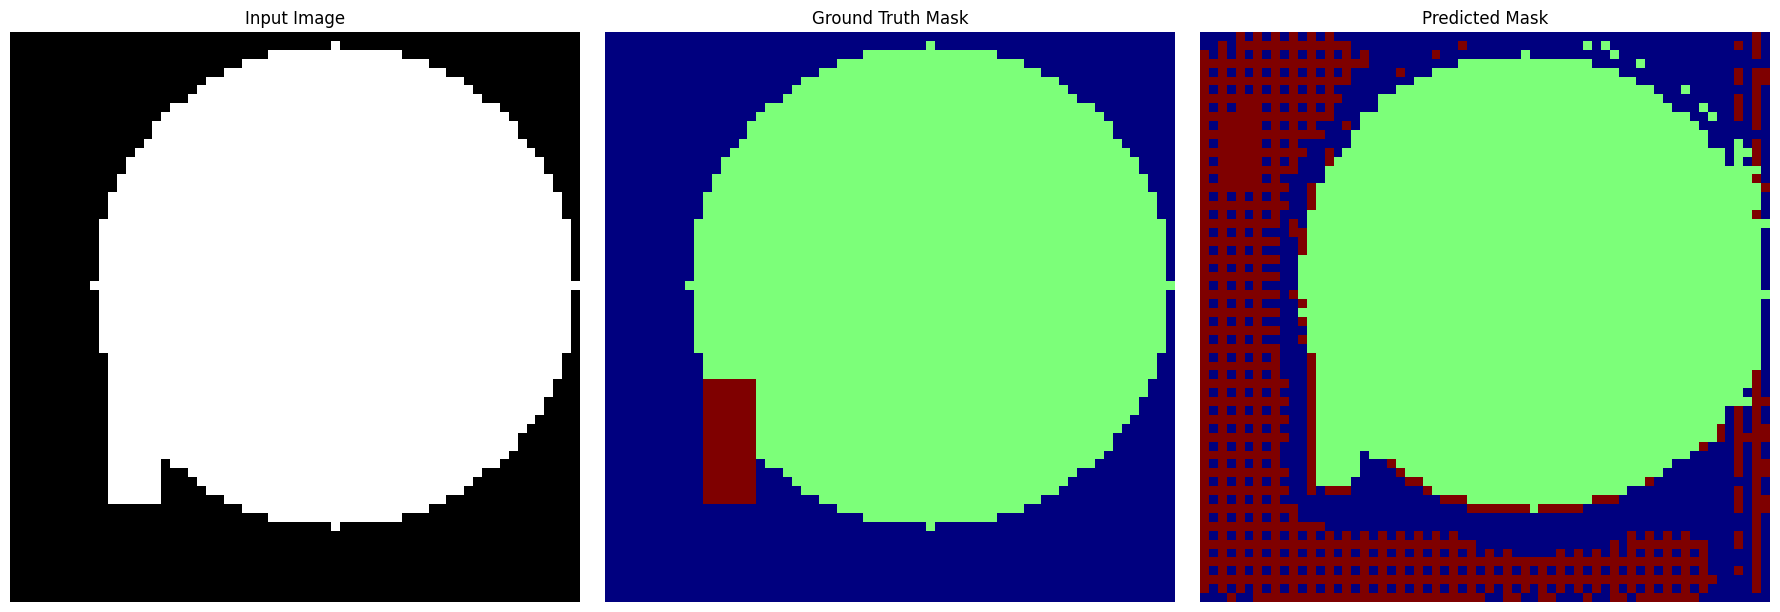

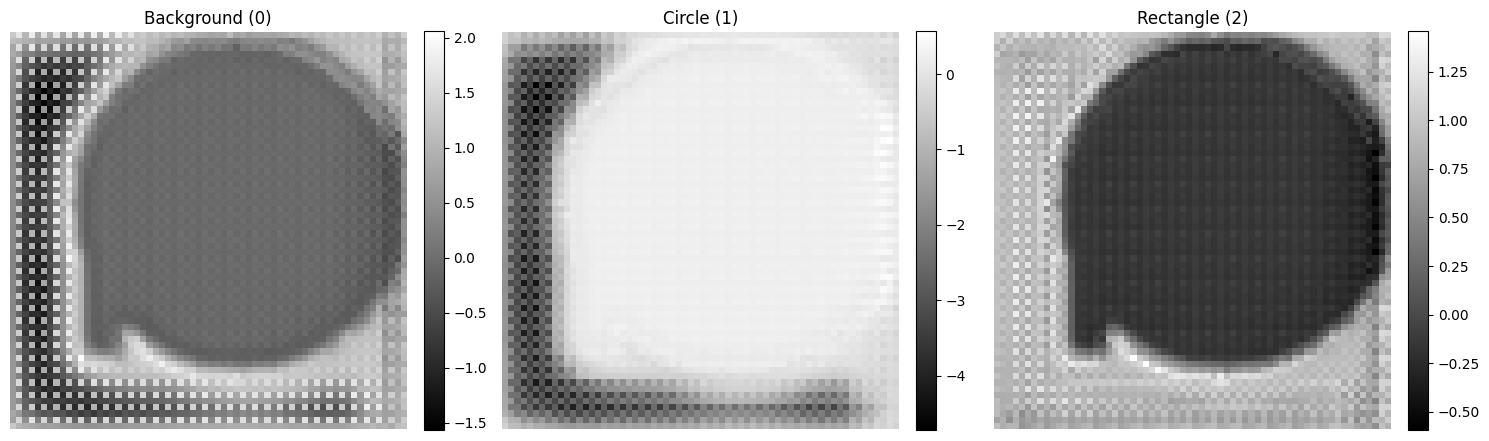

In [31]:
# Visualize one sample from the test set.
visualize_segmentation(model, test_dataloader, device, class_names=class_names)

# Instance segmentation

In [32]:
class MultiShapeInstanceSegmentationDataset(Dataset):
    def __init__(self, multi_shape_dataset):
        """
        Wraps a MultiShapeDataset to create an instance segmentation dataset.

        Args:
            multi_shape_dataset (Dataset): An instance of MultiShapeDataset.
        """
        self.multi_shape_dataset = multi_shape_dataset
        # image_size is provided as (width, height)
        self.image_size = multi_shape_dataset.image_size
        self.max_objects = multi_shape_dataset.max_objects

    def __len__(self):
        return len(self.multi_shape_dataset)

    def __getitem__(self, idx):
        # Get the original image and labels from the MultiShapeDataset.
        # img: Tensor of shape [1, H, W]
        # labels: Tensor of shape [max_objects, 5] where each label is
        #         [class, center_x, center_y, width, height] (normalized).
        img, labels = self.multi_shape_dataset[idx]

        # Convert labels to NumPy for easier processing.
        labels_np = labels.numpy()
        # Note: image_size is (width, height)
        W, H = self.image_size

        instance_masks = []
        instance_labels = []

        # Iterate over each label.
        for label in labels_np:
            cls = int(label[0])
            # Skip dummy labels (class == -1).
            if cls == -1:
                continue

            # Convert normalized coordinates to absolute pixel values.
            center_x = int(label[1] * W)
            center_y = int(label[2] * H)
            box_w = int(label[3] * W)
            box_h = int(label[4] * H)

            # Create an empty mask for this instance.
            mask = np.zeros((H, W), dtype=np.uint8)

            if cls == 0:
                # For a circle, we assume the bounding box is square.
                # Use half the width as radius.
                radius = box_w // 2
                yy, xx = np.ogrid[:H, :W]
                circle_mask = (xx - center_x)**2 + (yy - center_y)**2 <= radius**2
                mask[circle_mask] = 1
            else:
                # For a rectangle.
                x1 = max(0, center_x - box_w // 2)
                x2 = min(W, center_x + box_w // 2)
                y1 = max(0, center_y - box_h // 2)
                y2 = min(H, center_y + box_h // 2)
                mask[y1:y2, x1:x2] = 1

            instance_masks.append(torch.tensor(mask, dtype=torch.uint8))
            instance_labels.append(cls)

        # If no valid instance was found, return empty tensors.
        if len(instance_masks) == 0:
            instance_masks = torch.empty((0, H, W), dtype=torch.uint8)
            instance_labels = torch.empty((0,), dtype=torch.long)
        else:
            instance_masks = torch.stack(instance_masks, dim=0)  # [N, H, W]
            instance_labels = torch.tensor(instance_labels, dtype=torch.long)  # [N]

        return img, instance_masks, instance_labels

In [33]:
#############################################
# Instance Segmentation Model
#############################################

class InstanceSegmentationModel(nn.Module):
    def __init__(self, in_channels=1, num_instances=5, num_classes=2):
        """
        Args:
            in_channels (int): Number of input channels (e.g., 1 for grayscale images).
            num_instances (int): Fixed number of instance predictions per image.
            num_classes (int): Number of object classes (e.g., 2 for circle and rectangle).
        """
        super(InstanceSegmentationModel, self).__init__()
        self.num_instances = num_instances
        self.num_classes = num_classes

        # ----- Encoder -----
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.res_block1 = ResidualBlock(64, 64)   # [B, 64, H, W]
        self.pool1 = nn.MaxPool2d(2)               # [B, 64, H/2, W/2]
        self.res_block2 = ResidualBlock(64, 128)    # [B, 128, H/2, W/2]
        self.attention = CBAMAttention(128)         # [B, 128, H/2, W/2]
        self.pool2 = nn.MaxPool2d(2)               # [B, 128, H/4, W/4]
        self.res_block3 = ResidualBlock(128, 256)    # [B, 256, H/4, W/4]

        # ----- Classification Branch -----
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))   # [B, 256, 1, 1]
        self.fc = nn.Linear(256, num_instances * num_classes)  # → [B, num_instances*num_classes]

        # ----- Mask Branch (Decoder) -----
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsample to [B,128,H/2,W/2]
        self.res_block4 = ResidualBlock(128, 128)   # Refine features.
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # Upsample to [B,64,H,W]
        self.res_block5 = ResidualBlock(64, 64)      # Refine features.
        # Final convolution to produce instance masks (one channel per instance).
        self.mask_conv = nn.Conv2d(64, num_instances, kernel_size=1)

    def forward(self, x):
        # ----- Encoder -----
        x = self.initial_conv(x)         # [B, 64, H, W]
        x = self.res_block1(x)           # [B, 64, H, W]
        x = self.pool1(x)                # [B, 64, H/2, W/2]
        x = self.res_block2(x)           # [B, 128, H/2, W/2]
        x = self.attention(x)            # [B, 128, H/2, W/2]
        x = self.pool2(x)                # [B, 128, H/4, W/4]
        encoded = self.res_block3(x)     # [B, 256, H/4, W/4]

        # ----- Classification Branch -----
        pooled = self.avgpool(encoded)   # [B, 256, 1, 1]
        pooled = pooled.view(pooled.size(0), -1)  # [B, 256]
        cls_out = self.fc(pooled)        # [B, num_instances*num_classes]
        cls_out = cls_out.view(pooled.size(0), self.num_instances, self.num_classes)  # [B, num_instances, num_classes]

        # ----- Mask Branch -----
        x_mask = self.up1(encoded)       # [B, 128, H/2, W/2]
        x_mask = self.res_block4(x_mask)   # [B, 128, H/2, W/2]
        x_mask = self.up2(x_mask)        # [B, 64, H, W]
        x_mask = self.res_block5(x_mask)  # [B, 64, H, W]
        mask_out = self.mask_conv(x_mask)  # [B, num_instances, H, W]
        mask_out = torch.sigmoid(mask_out)  # Apply sigmoid to produce probabilities in [0,1].

        return mask_out, cls_out


In [34]:
def pad_instance_data(inst_masks_list, inst_labels_list, num_instances, H, W, dummy_label=-100):
    """
    Pad (or truncate) the instance segmentation targets for a batch.

    Args:
        inst_masks_list (list of Tensors): List of length B, each tensor with shape [N, H, W].
        inst_labels_list (list of Tensors): List of length B, each tensor with shape [N].
        num_instances (int): Fixed number of instance predictions (model output).
        H (int): Height of the image.
        W (int): Width of the image.
        dummy_label (int): Dummy label to use for padded instances.

    Returns:
        padded_masks: Tensor of shape [B, num_instances, H, W] (dtype: float32).
        padded_labels: Tensor of shape [B, num_instances] (dtype: long).
    """
    padded_masks = []
    padded_labels = []
    device = inst_masks_list[0].device  # assume all on same device

    for masks, labels in zip(inst_masks_list, inst_labels_list):
        N = masks.size(0)
        if N < num_instances:
            # Create padding masks (zeros) and dummy labels.
            pad_masks = torch.zeros((num_instances - N, H, W), dtype=masks.dtype, device=device)
            pad_labels = torch.full((num_instances - N,), dummy_label, dtype=labels.dtype, device=device)
            masks_padded = torch.cat([masks, pad_masks], dim=0)
            labels_padded = torch.cat([labels, pad_labels], dim=0)
        elif N > num_instances:
            masks_padded = masks[:num_instances]
            labels_padded = labels[:num_instances]
        else:
            masks_padded = masks
            labels_padded = labels
        padded_masks.append(masks_padded)
        padded_labels.append(labels_padded)

    padded_masks = torch.stack(padded_masks, dim=0)    # [B, num_instances, H, W]
    padded_labels = torch.stack(padded_labels, dim=0)    # [B, num_instances]
    # Convert masks to float for BCE loss.
    return padded_masks.float(), padded_labels

def train_instance_segmentation_model(model, dataloader, optimizer, mask_loss_fn, cls_loss_fn, device,
                                      num_epochs=20, num_instances=5, dummy_label=-100):
    """
    Trains the instance segmentation model.

    Args:
        model (nn.Module): The instance segmentation model.
        dataloader (DataLoader): DataLoader yielding tuples:
            (images, instance_masks_list, instance_labels_list), where:
                - images: Tensor of shape [B, 1, H, W]
                - instance_masks_list: list (length B) of Tensors of shape [N, H, W]
                - instance_labels_list: list (length B) of Tensors of shape [N]
        optimizer (torch.optim.Optimizer): Optimizer.
        mask_loss_fn (nn.Module): Loss function for mask prediction (e.g. nn.BCELoss()).
        cls_loss_fn (nn.Module): Loss function for classification (e.g. nn.CrossEntropyLoss(ignore_index=-100)).
        device (torch.device): Computation device.
        num_epochs (int): Number of epochs.
        num_instances (int): Fixed number of instances per image (model output).
        dummy_label (int): Label to use for padded instances.
    """
    model.to(device)
    model.train()

    running_loss = 0.0
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, inst_masks_list, inst_labels_list in dataloader:
            images = images.to(device)  # [B, 1, H, W]
            B, _, H, W = images.shape

            # Pad instance masks and labels to fixed shape.
            gt_masks, gt_labels = pad_instance_data(inst_masks_list, inst_labels_list, num_instances, H, W, dummy_label)
            gt_masks = gt_masks.to(device)      # [B, num_instances, H, W]
            gt_labels = gt_labels.to(device)    # [B, num_instances]

            optimizer.zero_grad()
            # Forward pass.
            mask_preds, cls_preds = model(images)
            # mask_preds: [B, num_instances, H, W] (after sigmoid)
            # cls_preds: [B, num_instances, num_classes]

            # Compute mask loss.
            # Only compute mask loss for valid (non-dummy) instances.
            valid_mask = (gt_labels != dummy_label)  # [B, num_instances] boolean
            if valid_mask.sum() > 0:
                mask_loss = mask_loss_fn(mask_preds[valid_mask], gt_masks[valid_mask])
            else:
                mask_loss = torch.tensor(0.0, device=device)

            # Compute classification loss.
            # Reshape predictions to [B*num_instances, num_classes]
            cls_preds_reshaped = cls_preds.view(-1, cls_preds.size(-1))
            gt_labels_reshaped = gt_labels.view(-1)
            cls_loss = cls_loss_fn(cls_preds_reshaped, gt_labels_reshaped)

            total_loss = mask_loss + cls_loss
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item() * images.size(0)

        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        running_loss += epoch_loss

    avg_loss = running_loss / num_epochs
    print(f"Training completed. Average Loss: {avg_loss:.4f}")

In [35]:
instance_seg_dataset = MultiShapeInstanceSegmentationDataset(dataset)

In [36]:
def instance_seg_collate(batch):
        """
        Custom collate function for instance segmentation.
        Expects batch to be a list of tuples: (image, instance_masks, instance_labels)
        Returns:
            images: Tensor of shape [B, 1, H, W]
            inst_masks_list: List of length B, each is a Tensor of shape [N, H, W]
            inst_labels_list: List of length B, each is a Tensor of shape [N]
        """
        images = [item[0] for item in batch]
        inst_masks_list = [item[1] for item in batch]
        inst_labels_list = [item[2] for item in batch]
        images = torch.stack(images, dim=0)
        return images, inst_masks_list, inst_labels_list

    # Example instantiation (adjust paths and parameters as needed):
    # from your_dataset_module import MultiShapeDataset, MultiShapeInstanceSegmentationDataset
    # base_dataset = MultiShapeDataset(num_samples=100, max_objects=5)
    # instance_seg_dataset = MultiShapeInstanceSegmentationDataset(base_dataset)

    # For demonstration, assume instance_seg_dataset is already created.
    # Create DataLoader.
dataloader = DataLoader(instance_seg_dataset, batch_size=8, shuffle=True,
                            collate_fn=instance_seg_collate, num_workers=2)

    # Instantiate the model.
model = InstanceSegmentationModel(in_channels=1, num_instances=5, num_classes=2)

    # Define optimizer.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Define loss functions.
    # For mask predictions, we use BCE loss.
mask_loss_fn = nn.BCELoss()
    # For classification, we use CrossEntropyLoss with ignore_index.
cls_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    # Set the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train the model.
train_instance_segmentation_model(model, dataloader, optimizer, mask_loss_fn, cls_loss_fn,
                                      device, num_epochs=20, num_instances=5, dummy_label=-100)

Epoch [1/20], Loss: 0.6311
Epoch [2/20], Loss: 0.4928
Epoch [3/20], Loss: 0.4974
Epoch [4/20], Loss: 0.4456
Epoch [5/20], Loss: 0.4166
Epoch [6/20], Loss: 0.4101
Epoch [7/20], Loss: 0.3756
Epoch [8/20], Loss: 0.3920
Epoch [9/20], Loss: 0.3579
Epoch [10/20], Loss: 0.3602
Epoch [11/20], Loss: 0.3320
Epoch [12/20], Loss: 0.3100
Epoch [13/20], Loss: 0.3126
Epoch [14/20], Loss: 0.3043
Epoch [15/20], Loss: 0.2877
Epoch [16/20], Loss: 0.3102
Epoch [17/20], Loss: 0.3056
Epoch [18/20], Loss: 0.2978
Epoch [19/20], Loss: 0.3022
Epoch [20/20], Loss: 0.2867
Training completed. Average Loss: 0.3714


In [37]:
#############################################
# Helper Functions
#############################################

def pad_instance_data(inst_masks_list, inst_labels_list, num_instances, H, W, dummy_label=-100):
    """
    Given a list of instance masks and instance labels for a batch,
    pad (or truncate) each to a fixed number of instances.

    Args:
        inst_masks_list (list of Tensors): length B; each Tensor of shape [N, H, W]
        inst_labels_list (list of Tensors): length B; each Tensor of shape [N]
        num_instances (int): fixed number of instances (model output)
        H, W (int): image dimensions.
        dummy_label (int): label used for padded instances.
    Returns:
        padded_masks: Tensor of shape [B, num_instances, H, W] (float32)
        padded_labels: Tensor of shape [B, num_instances] (long)
    """
    padded_masks = []
    padded_labels = []
    device = inst_masks_list[0].device
    for masks, labels in zip(inst_masks_list, inst_labels_list):
        N = masks.size(0)
        if N < num_instances:
            pad_masks = torch.zeros((num_instances - N, H, W), dtype=masks.dtype, device=device)
            pad_labels = torch.full((num_instances - N,), dummy_label, dtype=labels.dtype, device=device)
            masks_padded = torch.cat([masks, pad_masks], dim=0)
            labels_padded = torch.cat([labels, pad_labels], dim=0)
        elif N > num_instances:
            masks_padded = masks[:num_instances]
            labels_padded = labels[:num_instances]
        else:
            masks_padded = masks
            labels_padded = labels
        padded_masks.append(masks_padded)
        padded_labels.append(labels_padded)
    padded_masks = torch.stack(padded_masks, dim=0)  # [B, num_instances, H, W]
    padded_labels = torch.stack(padded_labels, dim=0)  # [B, num_instances]
    return padded_masks.float(), padded_labels

def compute_mask_iou(pred_mask, gt_mask):
    """
    Compute IoU between two binary masks.
    Both pred_mask and gt_mask are assumed to be torch tensors of type float.
    """
    intersection = (pred_mask * gt_mask).sum().item()
    union = (pred_mask + gt_mask - pred_mask * gt_mask).sum().item()
    if union == 0:
        return 1.0  # if both are empty, define IoU as 1
    return intersection / union

#############################################
# Inference and Performance Evaluation
#############################################

def evaluate_instance_segmentation_model(model, dataloader, device, num_instances, dummy_label=-100):
    """
    Runs inference on the test dataset and computes:
      - Classification accuracy (over valid instances)
      - Mean IoU over instance masks (for valid instances)

    Args:
        model (nn.Module): Instance segmentation model.
        dataloader (DataLoader): Yields tuples (images, inst_masks_list, inst_labels_list)
            - images: Tensor of shape [B, 1, H, W]
            - inst_masks_list: list of length B; each element is a Tensor of shape [N, H, W]
            - inst_labels_list: list of length B; each element is a Tensor of shape [N]
        device (torch.device): Computation device.
        num_instances (int): Fixed number of instance predictions (model output).
        dummy_label (int): Label used for padded instances.
    Returns:
        avg_cls_acc (float): Average classification accuracy.
        avg_mask_iou (float): Average IoU over valid instance masks.
    """
    model.to(device)
    model.eval()

    total_valid = 0
    correct_cls = 0
    total_mask_iou = 0.0

    with torch.no_grad():
        for images, gt_inst_masks_list, gt_inst_labels_list in dataloader:
            images = images.to(device)  # [B, 1, H, W]
            B, _, H, W = images.shape

            # Pad ground truth instance data.
            gt_masks, gt_labels = pad_instance_data(gt_inst_masks_list, gt_inst_labels_list,
                                                    num_instances, H, W, dummy_label)
            gt_masks = gt_masks.to(device)     # [B, num_instances, H, W]
            gt_labels = gt_labels.to(device)   # [B, num_instances]

            # Forward pass.
            pred_masks, pred_cls_logits = model(images)
            # pred_masks: [B, num_instances, H, W] with sigmoid outputs.
            # pred_cls_logits: [B, num_instances, num_classes]
            pred_cls = torch.argmax(pred_cls_logits, dim=-1)  # [B, num_instances]
            # Threshold predicted masks at 0.5 to obtain binary masks.
            pred_masks_bin = (pred_masks > 0.5).float()

            valid_mask = (gt_labels != dummy_label)  # [B, num_instances]
            valid_count = valid_mask.sum().item()
            total_valid += valid_count

            # Classification accuracy over valid instances.
            correct_cls += ((pred_cls == gt_labels) & valid_mask).sum().item()

            # For each valid instance, compute IoU.
            for b in range(B):
                for i in range(num_instances):
                    if valid_mask[b, i]:
                        iou_val = compute_mask_iou(pred_masks_bin[b, i], gt_masks[b, i].float())
                        total_mask_iou += iou_val

    avg_cls_acc = correct_cls / total_valid if total_valid > 0 else 0
    avg_mask_iou = total_mask_iou / total_valid if total_valid > 0 else 0
    print(f"Instance Segmentation - Classification Accuracy: {avg_cls_acc*100:.2f}%")
    print(f"Instance Segmentation - Mean Mask IoU: {avg_mask_iou:.4f}")

    return avg_cls_acc, avg_mask_iou

#############################################
# Visualization of a Sample
#############################################

def visualize_instance_segmentation(model, dataloader, device, class_names=None,
                                    num_instances=5, dummy_label=-100):
    """
    Visualizes one sample from the test set. The visualization shows:
      1. The input image.
      2. An overlay of the ground-truth instance masks.
      3. An overlay of the predicted instance masks.
      4. For each valid instance, a side-by-side view of the ground-truth and predicted mask along with the class labels.

    Args:
        model (nn.Module): Instance segmentation model.
        dataloader (DataLoader): Yields tuples (images, inst_masks_list, inst_labels_list)
        device (torch.device): Computation device.
        class_names (list or None): Optional list of class names. If provided, used to label classes.
        num_instances (int): Fixed number of instance predictions.
        dummy_label (int): Label used for padded instances.
    """
    model.to(device)
    model.eval()

    with torch.no_grad():
        images, gt_inst_masks_list, gt_inst_labels_list = next(iter(dataloader))
        images = images.to(device)
        B, _, H, W = images.shape

        # Pad ground truth instance data.
        gt_masks, gt_labels = pad_instance_data(gt_inst_masks_list, gt_inst_labels_list,
                                                num_instances, H, W, dummy_label)
        gt_masks = gt_masks.to(device)
        gt_labels = gt_labels.to(device)

        # Forward pass.
        pred_masks, pred_cls_logits = model(images)
        pred_cls = torch.argmax(pred_cls_logits, dim=-1)
        pred_masks_bin = (pred_masks > 0.5).float()

    # For visualization, select the first image in the batch.
    image_np = images[0].cpu().squeeze(0).numpy()  # [H, W]

    # Ground truth instance data for the first image.
    gt_masks_np = gt_masks[0].cpu().numpy()   # [num_instances, H, W]
    gt_labels_np = gt_labels[0].cpu().numpy()   # [num_instances]

    # Predicted instance data for the first image.
    pred_masks_np = pred_masks_bin[0].cpu().numpy()  # [num_instances, H, W]
    pred_cls_np = pred_cls[0].cpu().numpy()          # [num_instances]

    # Create a color map for instances.
    cmap = plt.cm.get_cmap("hsv", num_instances)

    # Figure 1: Input image, overlay of ground truth and overlay of predictions.
    fig1, axs1 = plt.subplots(1, 3, figsize=(18, 6))

    axs1[0].imshow(image_np, cmap='gray')
    axs1[0].set_title("Input Image")
    axs1[0].axis('off')

    # Create overlay for ground truth.
    overlay_gt = np.zeros((H, W, 3), dtype=np.float32)
    for i in range(num_instances):
        if gt_labels_np[i] == dummy_label:
            continue
        color = cmap(i)[:3]
        overlay_gt[gt_masks_np[i] == 1] = color
    axs1[1].imshow(image_np, cmap='gray')
    axs1[1].imshow(overlay_gt, alpha=0.5)
    axs1[1].set_title("Ground Truth Instances")
    axs1[1].axis('off')

    # Create overlay for predictions.
    overlay_pred = np.zeros((H, W, 3), dtype=np.float32)
    for i in range(num_instances):
        # You may choose to overlay only predictions with high confidence (if available).
        color = cmap(i)[:3]
        overlay_pred[pred_masks_np[i] == 1] = color
    axs1[2].imshow(image_np, cmap='gray')
    axs1[2].imshow(overlay_pred, alpha=0.5)
    axs1[2].set_title("Predicted Instances")
    axs1[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Figure 2: For each valid instance, show side-by-side ground truth and prediction.
    valid_indices = [i for i in range(num_instances) if gt_labels_np[i] != dummy_label]
    num_valid = len(valid_indices)
    if num_valid == 0:
        print("No valid instances to visualize.")
        return
    fig2, axs2 = plt.subplots(1, num_valid, figsize=(4*num_valid, 4))
    if num_valid == 1:
        axs2 = [axs2]
    for idx, inst_idx in enumerate(valid_indices):
        gt_mask_img = gt_masks_np[inst_idx]
        pred_mask_img = pred_masks_np[inst_idx]
        # Concatenate ground truth and predicted masks horizontally.
        combined = np.concatenate([gt_mask_img, pred_mask_img], axis=1)
        title = f"Inst {inst_idx}\nGT: {gt_labels_np[inst_idx]}"
        if class_names is not None and gt_labels_np[inst_idx] < len(class_names):
            title = f"Inst {inst_idx}\nGT: {class_names[int(gt_labels_np[inst_idx])]}\nPred: {class_names[int(pred_cls_np[inst_idx])]}"
        else:
            title = f"Inst {inst_idx}\nGT: {gt_labels_np[inst_idx]}\nPred: {pred_cls_np[inst_idx]}"
        axs2[idx].imshow(combined, cmap='gray')
        axs2[idx].set_title(title)
        axs2[idx].axis('off')
    plt.tight_layout()
    plt.show()

Instance Segmentation - Classification Accuracy: 90.84%
Instance Segmentation - Mean Mask IoU: 0.4881


<ipython-input-37-91cc4d328bd7>:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", num_instances)


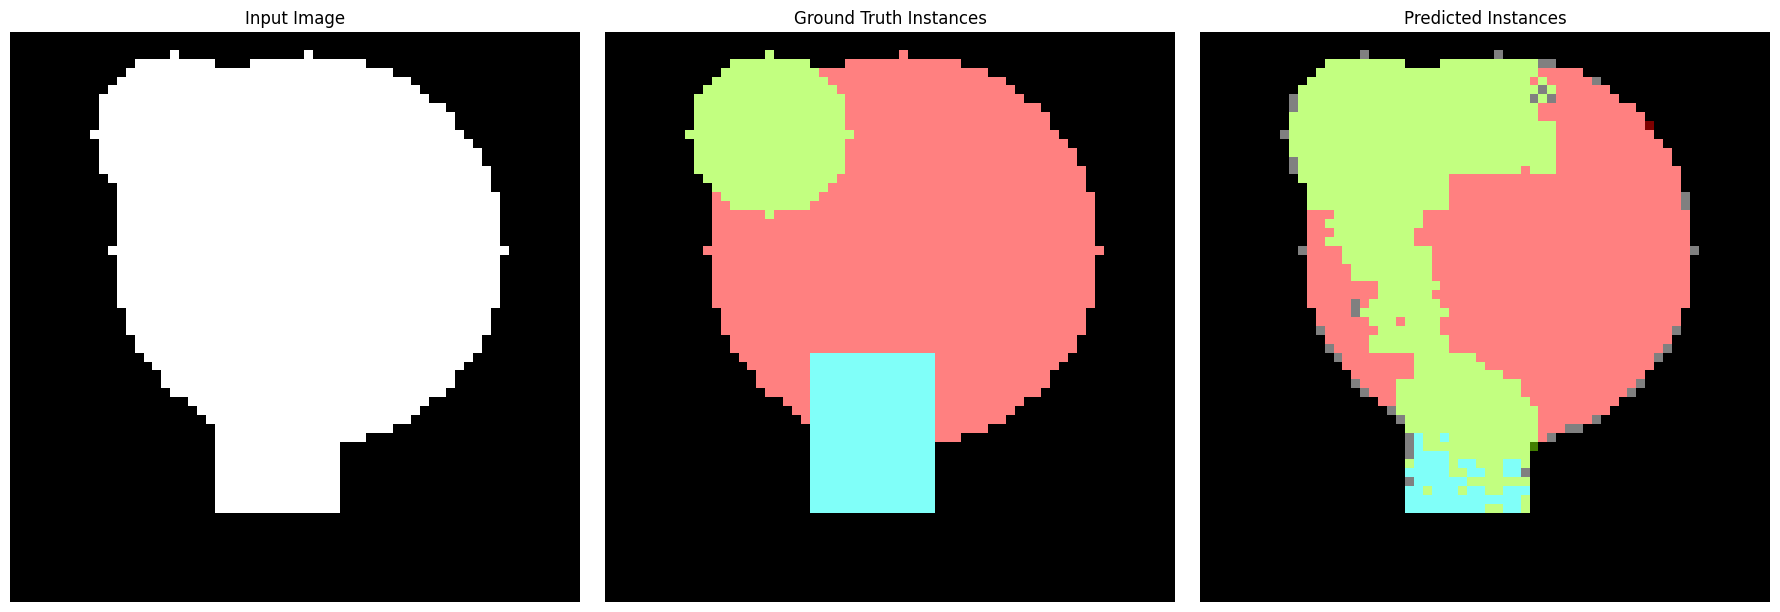

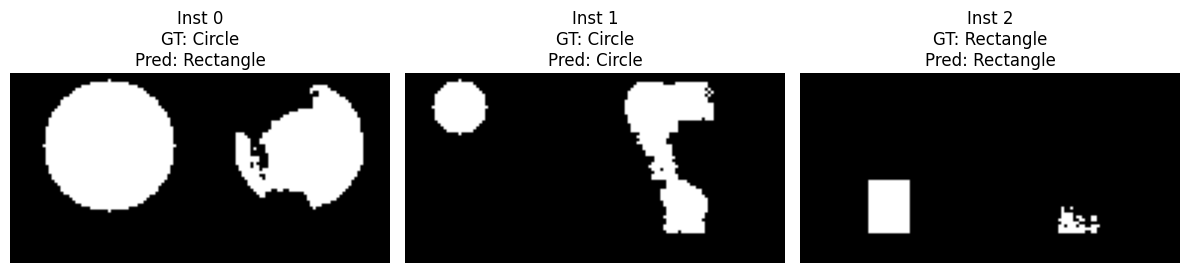

In [38]:
    # Assume that:
    # 1. instance_seg_dataset is an instance segmentation dataset that returns:
    #       (image, instance_masks, instance_labels)
    #    where:
    #       image: Tensor of shape [1, H, W]
    #       instance_masks: Tensor of shape [N, H, W] (binary)
    #       instance_labels: Tensor of shape [N]
    # 2. The model is an instance of InstanceSegmentationModel.
    #
    # Because the dataset returns a variable number of instances per image, a custom collate
    # function is used.

def instance_seg_collate(batch):
        images = [item[0] for item in batch]
        inst_masks_list = [item[1] for item in batch]
        inst_labels_list = [item[2] for item in batch]
        images = torch.stack(images, dim=0)
        return images, inst_masks_list, inst_labels_list

    # Example: create a DataLoader.
    # (Make sure that instance_seg_dataset and InstanceSegmentationModel are defined and imported.)
test_dataloader = DataLoader(instance_seg_dataset, batch_size=4, shuffle=False,
                                 collate_fn=instance_seg_collate, num_workers=2)

    # Assume the model is already instantiated (e.g., with num_instances=5, num_classes=2).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate the instance segmentation model.
evaluate_instance_segmentation_model(model, test_dataloader, device, num_instances=5, dummy_label=-100)

    # Visualize one sample from the test set.
visualize_instance_segmentation(model, test_dataloader, device,
                                    class_names=["Circle", "Rectangle"],
                                    num_instances=5, dummy_label=-100)

# Lab 10.5 เปลี่ยนจำนวน num_instances และวิเคราะห์ผลลัพธ์

**เป้าหมาย:** ดูผลการเทรนเมื่อโมเดลถูกจำกัดให้ทำนายได้มากกว่าหรือน้อยกว่าจำนวนวัตถุในภาพ

1. ลองตั้ง num_instances=3 แทน 5 (ค่าเริ่มต้น) แล้วเช็คว่า Dataset ที่มีภาพซึ่งอาจมีมากกว่า 3 object จะถูก “truncate” หรือ “pad” อย่างไร
2. สังเกตว่า:
 * บางภาพมี 4–5 วัตถุจริง แต่โมเดลได้ทำนายเพียง 3 instance (ที่เหลือถูกตัดทิ้ง)
 * บางภาพมี 1 วัตถุจริง แต่ต้อง pad dummy ถึง 2 instance
3. จดบันทึกค่า Loss และผลลัพธ์สุดท้ายบนภาพ (visualize mask และคลาส) เทียบกับกรณี num_instances=5

**คำถาม:**

1. เมื่อ num_instances น้อยกว่าจำนวนวัตถุจริงในภาพมาก ๆ โมเดลจะทายวัตถุบางส่วนถูกไหม?
2. ถ้าเพิ่ม num_instances สูงเกินไปเกิด dummy เยอะ, Loss มีปัญหาหรือไม่?

In [39]:
def instance_seg_collate(batch):
        """
        Custom collate function for instance segmentation.
        Expects batch to be a list of tuples: (image, instance_masks, instance_labels)
        Returns:
            images: Tensor of shape [B, 1, H, W]
            inst_masks_list: List of length B, each is a Tensor of shape [N, H, W]
            inst_labels_list: List of length B, each is a Tensor of shape [N]
        """
        images = [item[0] for item in batch]
        inst_masks_list = [item[1] for item in batch]
        inst_labels_list = [item[2] for item in batch]
        images = torch.stack(images, dim=0)
        return images, inst_masks_list, inst_labels_list

    # Example instantiation (adjust paths and parameters as needed):
    # from your_dataset_module import MultiShapeDataset, MultiShapeInstanceSegmentationDataset
    # base_dataset = MultiShapeDataset(num_samples=100, max_objects=3)
    # instance_seg_dataset = MultiShapeInstanceSegmentationDataset(base_dataset)

    # For demonstration, assume instance_seg_dataset is already created.
    # Create DataLoader.
dataloader = DataLoader(instance_seg_dataset, batch_size=8, shuffle=True,
                            collate_fn=instance_seg_collate, num_workers=2)

    # Instantiate the model.
model = InstanceSegmentationModel(in_channels=1, num_instances=3, num_classes=2)

    # Define optimizer.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Define loss functions.
    # For mask predictions, we use BCE loss.
mask_loss_fn = nn.BCELoss()
    # For classification, we use CrossEntropyLoss with ignore_index.
cls_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    # Set the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train the model.
train_instance_segmentation_model(model, dataloader, optimizer, mask_loss_fn, cls_loss_fn,
                                      device, num_epochs=20, num_instances=3, dummy_label=-100)

Epoch [1/20], Loss: 0.6150
Epoch [2/20], Loss: 0.4675
Epoch [3/20], Loss: 0.4375
Epoch [4/20], Loss: 0.4244
Epoch [5/20], Loss: 0.4190
Epoch [6/20], Loss: 0.3920
Epoch [7/20], Loss: 0.3878
Epoch [8/20], Loss: 0.3485
Epoch [9/20], Loss: 0.3507
Epoch [10/20], Loss: 0.3295
Epoch [11/20], Loss: 0.3251
Epoch [12/20], Loss: 0.3251
Epoch [13/20], Loss: 0.2971
Epoch [14/20], Loss: 0.2929
Epoch [15/20], Loss: 0.3155
Epoch [16/20], Loss: 0.2822
Epoch [17/20], Loss: 0.2443
Epoch [18/20], Loss: 0.2658
Epoch [19/20], Loss: 0.2508
Epoch [20/20], Loss: 0.2566
Training completed. Average Loss: 0.3514


Instance Segmentation - Classification Accuracy: 93.86%
Instance Segmentation - Mean Mask IoU: 0.5181


<ipython-input-37-91cc4d328bd7>:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", num_instances)


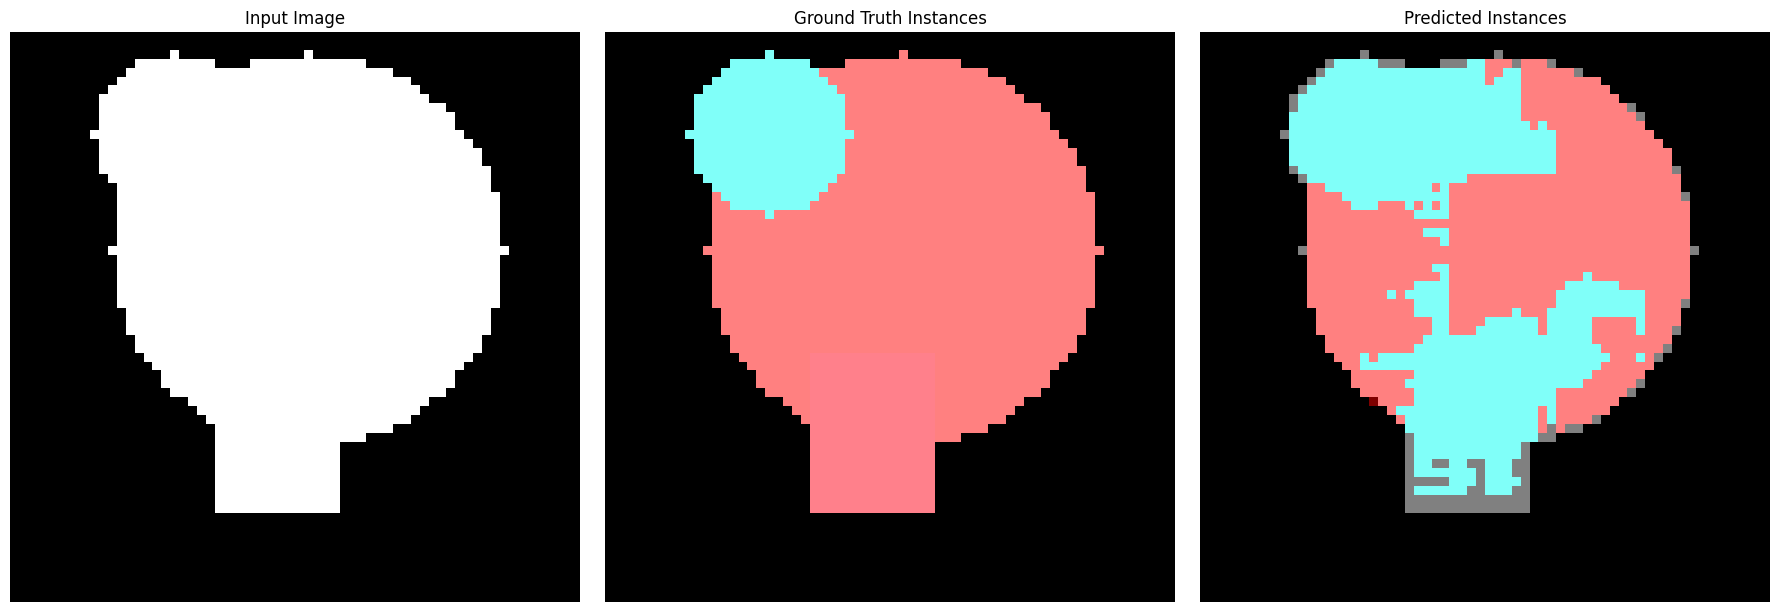

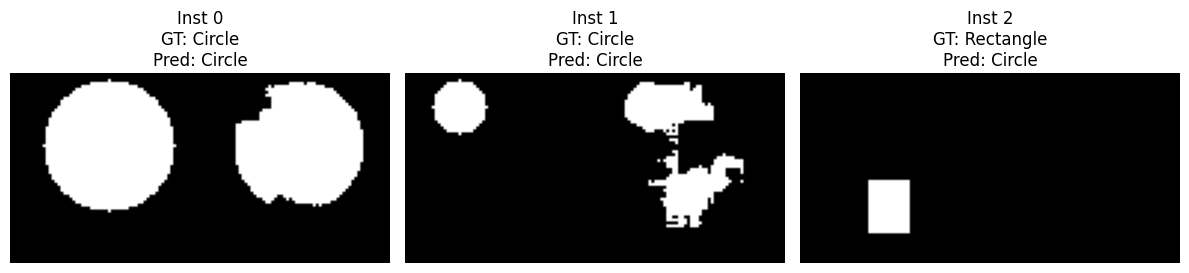

In [40]:
    # Assume that:
    # 1. instance_seg_dataset is an instance segmentation dataset that returns:
    #       (image, instance_masks, instance_labels)
    #    where:
    #       image: Tensor of shape [1, H, W]
    #       instance_masks: Tensor of shape [N, H, W] (binary)
    #       instance_labels: Tensor of shape [N]
    # 2. The model is an instance of InstanceSegmentationModel.
    #
    # Because the dataset returns a variable number of instances per image, a custom collate
    # function is used.

def instance_seg_collate(batch):
        images = [item[0] for item in batch]
        inst_masks_list = [item[1] for item in batch]
        inst_labels_list = [item[2] for item in batch]
        images = torch.stack(images, dim=0)
        return images, inst_masks_list, inst_labels_list

    # Example: create a DataLoader.
    # (Make sure that instance_seg_dataset and InstanceSegmentationModel are defined and imported.)
test_dataloader = DataLoader(instance_seg_dataset, batch_size=4, shuffle=False,
                                 collate_fn=instance_seg_collate, num_workers=2)

    # Assume the model is already instantiated (e.g., with num_instances=3, num_classes=2).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate the instance segmentation model.
evaluate_instance_segmentation_model(model, test_dataloader, device, num_instances=3, dummy_label=-100)

    # Visualize one sample from the test set.
visualize_instance_segmentation(model, test_dataloader, device,
                                    class_names=["Circle", "Rectangle"],
                                    num_instances=3, dummy_label=-100)